In [8]:
import re
import pandas as pd
import numpy as np
from collections import defaultdict

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# nltk
from nltk import tokenize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from tqdm import tqdm_notebook as tqdm
from tqdm import trange

In [4]:
books = ["data/Rowling, J.K. - HP 1 - Harry Potter and the Sorcerer's Stone.txt",
         "data/Rowling, J.K. - HP 2 - Harry Potter and the Chamber of Secrets.txt",
         "data/Rowling, J.K. - HP 3 - Harry Potter and the Prisoner of Azkaban.txt",
         "data/Rowling, J.K. - HP 4 - Harry Potter and the Goblet of Fire.txt",
         "data/Rowling, J.K. - HP 5 - Harry Potter and the Order of the Phoenix.txt",
         "data/Rowling, J.K. - HP 6 - Harry Potter and the Half-Blood Prince.txt",
         "data/Rowling, J.K. - HP 7 - Harry Potter and the Deathly Hallows.txt"]

In [5]:
pattern = ("(C H A P T E R (?:[A-Z-][ ]){2,}[A-Z]|"
           "E P I L O G U E)\s+" +                   # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + # Group 2 selects the chapter title but excludes all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                     # chapter title ends before lowercase letters or a period
           "(.*?)" +                                 # Group 3 selects the chapter contents
           "(?=C H A P T E R (?:[A-Z][ ]){2,}|"
           "This\s+book\s+was\s+art\s+directed\s+|"
           "E P I L O G U E)")                       # chapter contents ends with a new chapter, epilogue or the end of book
hp = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = (f.read().replace('&rsquo;', "'")
                        .replace('&lsquo;', "'")
                        .replace('&rdquo;', '"')
                        .replace('&ldquo;', '"')
                        .replace('&mdash;', '—'))
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = chapter[2][3:]
        phrase = ' HE-WHO-MUST-NOT-BE-NAMED RETURNS'
        if phrase in chap_title:
            chap_title = chap_title.replace(phrase, '')
            chap_text = phrase[1:] + ' I' + chap_text
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull;\s*(CHAPTER [A-Z-]+\s*)|(EPILOGUE)\s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
        hp[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp = dict(hp)
hp["Harry Potter and the Deathly Hallows"]['Epilogue'] = hp["Harry Potter and the Deathly Hallows"].pop('Chapter 37')

FileNotFoundError: [Errno 2] No such file or directory: "data/Rowling, J.K. - HP 1 - Harry Potter and the Sorcerer's Stone.txt"

### The format of the Harry Potter hp dictionary is as follows:
&nbsp;   
{book 1 title: {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 2': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 3': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 'book 2 title': {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 &nbsp;...  
}  

In [4]:
analyzer = SentimentIntensityAnalyzer()

In [5]:
for book in tqdm(hp, desc='Progress'):
    print(book)
    for chapter in tqdm(hp[book], postfix=book):
#         print('  ', hp[book][chapter][0])
        text = hp[book][chapter][1].replace('\n', '')
        sentence_list = tokenize.sent_tokenize(text)
        sentiments = {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}
        
        for sentence in sentence_list:
            vs = analyzer.polarity_scores(sentence)
            sentiments['compound'] += vs['compound']
            sentiments['neg'] += vs['neg']
            sentiments['neu'] += vs['neu']
            sentiments['pos'] += vs['pos']
            
        sentiments['compound'] = sentiments['compound'] / len(sentence_list)
        sentiments['neg'] = sentiments['neg'] / len(sentence_list)
        sentiments['neu'] = sentiments['neu'] / len(sentence_list)
        sentiments['pos'] = sentiments['pos'] / len(sentence_list)

        hp[book][chapter] = (hp[book][chapter][0], hp[book][chapter][1], sentiments)
#     print()

HBox(children=(IntProgress(value=0, description='Progress', max=7), HTML(value='')))

Harry Potter and the Sorcerer's Stone


HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

Harry Potter and the Chamber of Secrets


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

Harry Potter and the Prisoner of Azkaban


HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

Harry Potter and the Goblet of Fire


HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


Harry Potter and the Order of the Phoenix


HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

Harry Potter and the Half-Blood Prince


HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

Harry Potter and the Deathly Hallows


HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

In [6]:
compound_sentiments = [hp[book][chapter][2]['compound'] for book in hp for chapter in hp[book]]

In [7]:
chap = 0
for book in hp:
    print(book)
    book_chap = 1
    for chapter in hp[book]:
        print('  Chapter', book_chap, '-', hp[book][chapter][0])
        print('     ', compound_sentiments[chap])
        book_chap += 1
        chap += 1
    print()

Harry Potter and the Sorcerer's Stone
  Chapter 1 - THE BOY WHO LIVED
      0.035601173708920186
  Chapter 2 - THE VANISHING GLASS
      -0.018699275362318843
  Chapter 3 - THE LETTERS FROM NO ONE
      0.0008134502923976618
  Chapter 4 - THE KEEPER OF THE KEYS
      -0.02304878048780488
  Chapter 5 - DIAGON ALLEY
      0.04538205128205131
  Chapter 6 - THE JOURNEY FROM PLATFORM NINE AND THREE-QUARTERS
      0.026414975041597337
  Chapter 7 - THE SORTING HAT
      0.04281226666666667
  Chapter 8 - THE POTIONS MASTER
      0.023844499999999984
  Chapter 9 - THE MIDNIGHT DUEL
      -0.001744028103044498
  Chapter 10 - HALLOWEEN
      0.03709796511627909
  Chapter 11 - QUIDDITCH
      -0.0017154929577464844
  Chapter 12 - THE MIRROR OF ERISED
      0.03331609442060086
  Chapter 13 - NICHOLAS FLAMEL
      0.01425472972972973
  Chapter 14 - NORBERT THE NORWEGIAN RIDGEBACK
      0.012651219512195127
  Chapter 15 - THE FORBIDDEN FOREST
      -0.04717451737451737
  Chapter 16 - THROUGH THE TRA

In [8]:
book_indices = {}
idx = 0
for book in hp:
    start = idx
    for chapter in hp[book]:
        idx += 1
    book_indices[book] = (start, idx)

In [9]:
book_indices

{'Harry Potter and the Chamber of Secrets': (17, 35),
 'Harry Potter and the Deathly Hallows': (162, 199),
 'Harry Potter and the Goblet of Fire': (57, 94),
 'Harry Potter and the Half-Blood Prince': (132, 162),
 'Harry Potter and the Order of the Phoenix': (94, 132),
 'Harry Potter and the Prisoner of Azkaban': (35, 57),
 "Harry Potter and the Sorcerer's Stone": (0, 17)}

In [10]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

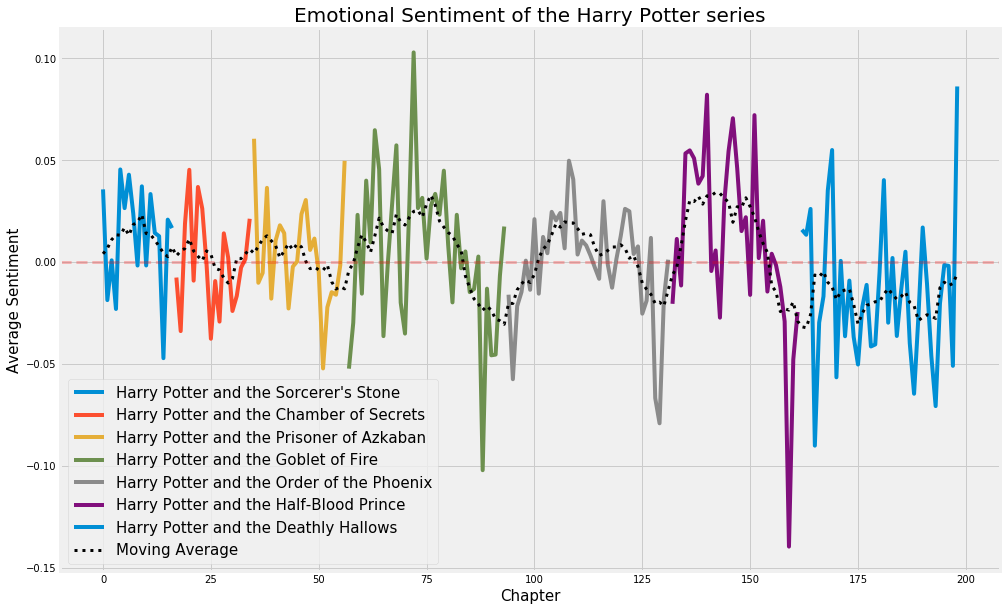

In [11]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)
y = [hp[book][chapter][2]['compound'] for book in hp for chapter in hp[book]]

plt.figure(figsize=(15, 10))
for book in book_indices:
    plt.plot(x[book_indices[book][0]: book_indices[book][1]],
             y[book_indices[book][0]: book_indices[book][1]],
             label=book)
plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Emotional Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

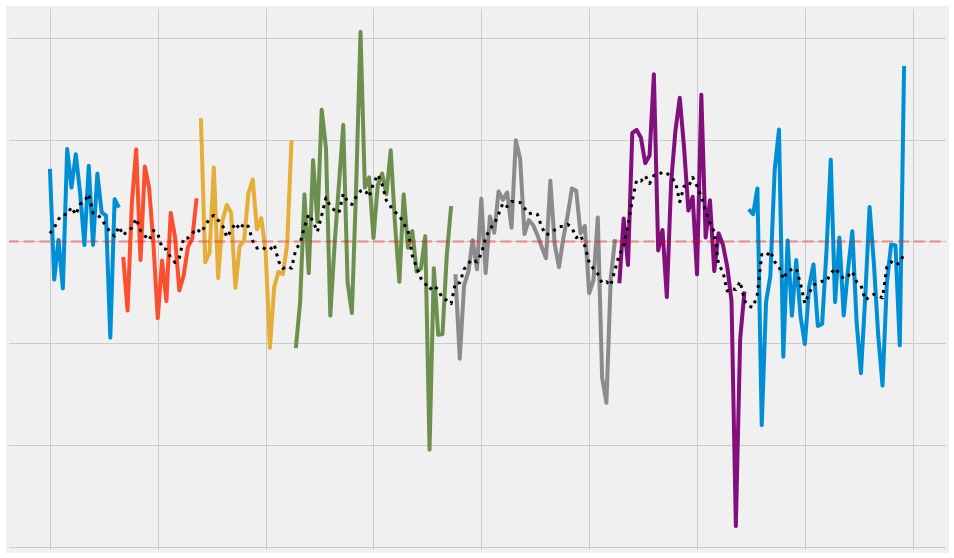

In [12]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)
y = [hp[book][chapter][2]['compound'] for book in hp for chapter in hp[book]]

plt.figure(figsize=(15, 10))
for book in book_indices:
    plt.plot(x[book_indices[book][0]: book_indices[book][1]],
             y[book_indices[book][0]: book_indices[book][1]],
             label=book)
plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.xticks(np.arange(0, 225, 25), '')
plt.yticks(np.arange(-.15, .15, .05), '')
plt.show()

In [13]:
sentiment_scores = [[hp[book][chapter][2][sentiment] for book in hp for chapter in hp[book]]
                    for sentiment in ['compound', 'neg', 'neu', 'pos']]

In [14]:
compound_sentiment = sentiment_scores[0]
print('Average Book Sentiment:')
print()
for book in book_indices:
    compound = compound_sentiment[book_indices[book][0]: book_indices[book][1]]
    print('{:45}{:.2f}%'.format(book, 100 * sum(compound) / len(compound)))
print('{:45}{:.2f}%'.format('Across the entire series', 100 * sum(compound_sentiment) / len(compound_sentiment)))

Average Book Sentiment:

Harry Potter and the Sorcerer's Stone        1.28%
Harry Potter and the Chamber of Secrets      -0.03%
Harry Potter and the Prisoner of Azkaban     0.41%
Harry Potter and the Goblet of Fire          0.51%
Harry Potter and the Order of the Phoenix    -0.06%
Harry Potter and the Half-Blood Prince       1.08%
Harry Potter and the Deathly Hallows         -1.52%
Across the entire series                     0.11%


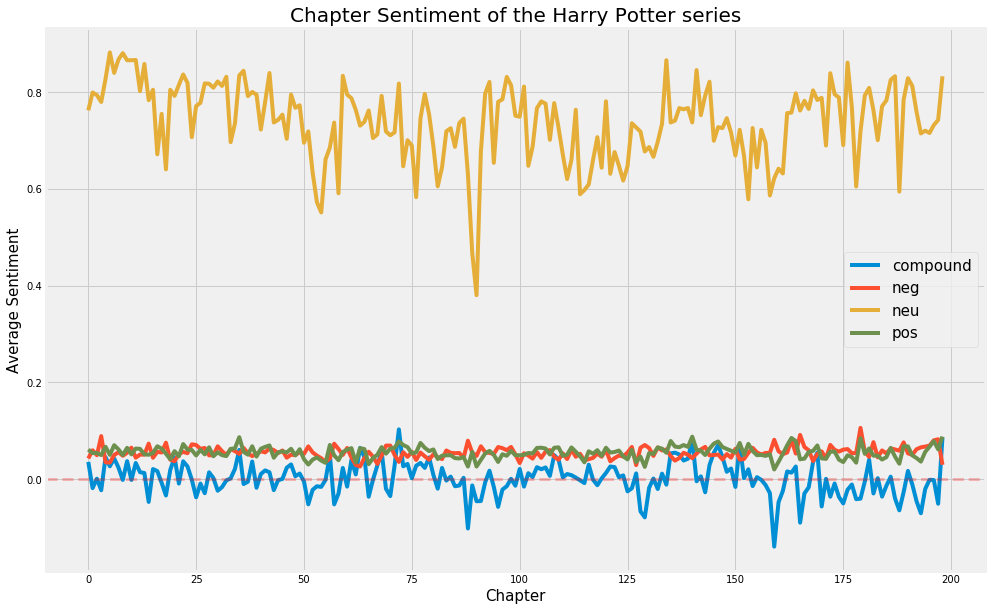

In [15]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)

plt.figure(figsize=(15, 10))
for i, sentiment in enumerate(sentiment_scores):
    plt.plot(x,
             sentiment,
             label=['compound', 'neg', 'neu', 'pos'][i])
# plt.plot(movingaverage(compound_sentiments, 10)+.1, color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Chapter Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

# Testing - analyze whole chapter instead of average of sentences

In [16]:
pattern = ("(C H A P T E R (?:[A-Z-][ ]){2,}[A-Z]|"
           "E P I L O G U E)\s+" +                   # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + # Group 2 selects the chapter title but excludes all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                     # chapter title ends before lowercase letters or a period
           "(.*?)" +                                 # Group 3 selects the chapter contents
           "(?=C H A P T E R (?:[A-Z][ ]){2,}|"
           "This\s+book\s+was\s+art\s+directed\s+|"
           "E P I L O G U E)")                       # chapter contents ends with a new chapter, epilogue or the end of book
hp2 = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = (f.read().replace('&rsquo;', "'")
                        .replace('&lsquo;', "'")
                        .replace('&rdquo;', '"')
                        .replace('&ldquo;', '"')
                        .replace('&mdash;', '—'))
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = chapter[2][3:]
        phrase = ' HE-WHO-MUST-NOT-BE-NAMED RETURNS'
        if phrase in chap_title:
            chap_title = chap_title.replace(phrase, '')
            chap_text = phrase[1:] + ' I' + chap_text
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull;\s*(CHAPTER [A-Z-]+\s*)|(EPILOGUE)\s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
        hp2[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp2 = dict(hp2)
hp2["Harry Potter and the Deathly Hallows"]['Epilogue'] = hp2["Harry Potter and the Deathly Hallows"].pop('Chapter 37')

In [17]:
for book in tqdm(hp2, desc='Progress'):
    print(book)
    for chapter in tqdm(hp2[book]):
#         print('  ', hp2[book][chapter][0])
        text = hp2[book][chapter][1].replace('\n', '')
        sentence_list = tokenize.sent_tokenize(text)
        sentiments2 = {'compound': [], 'neg': [], 'neu': [], 'pos': []}
        
        vs = analyzer.polarity_scores(text)
        sentiments2['compound'] = vs['compound']
        sentiments2['neg'] = vs['neg']
        sentiments2['neu'] = vs['neu']
        sentiments2['pos'] = vs['pos']

        hp2[book][chapter] = (hp2[book][chapter][0], hp2[book][chapter][1], sentiments2)
#     print()

HBox(children=(IntProgress(value=0, description='Progress', max=7), HTML(value='')))

Harry Potter and the Sorcerer's Stone


HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


Harry Potter and the Chamber of Secrets


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

Harry Potter and the Prisoner of Azkaban


HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

Harry Potter and the Goblet of Fire


HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

Harry Potter and the Order of the Phoenix


HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

Harry Potter and the Half-Blood Prince


HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

Harry Potter and the Deathly Hallows


HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

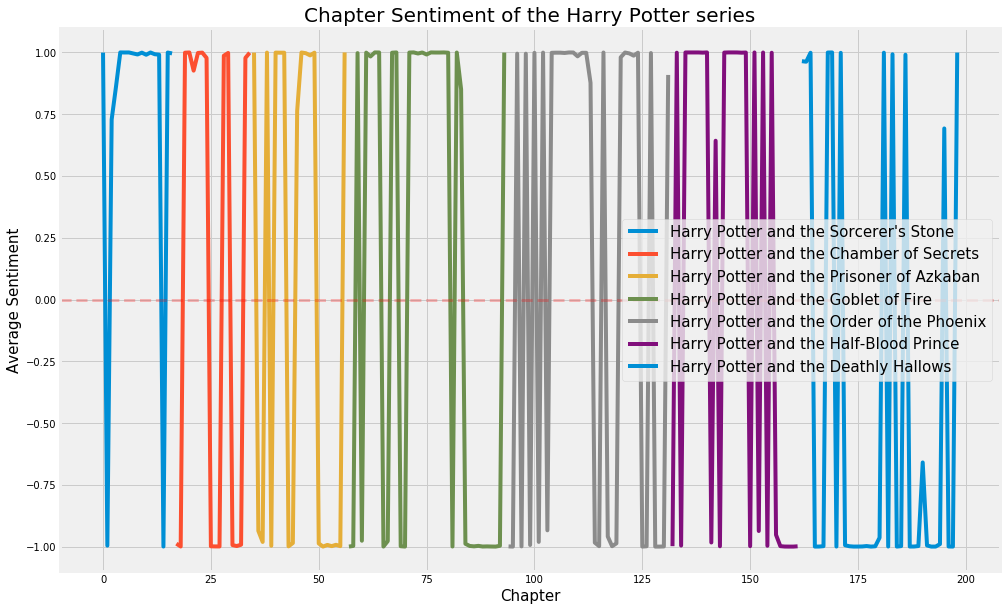

In [18]:
length = sum([len(hp2[book]) for book in hp2])
x = np.linspace(0, length - 1, num=length)
y = [hp2[book][chapter][2]['compound'] for book in hp2 for chapter in hp2[book]]

plt.figure(figsize=(15, 10))
for book in book_indices:
    plt.plot(x[book_indices[book][0]: book_indices[book][1]],
             y[book_indices[book][0]: book_indices[book][1]],
             label=book)
# plt.plot(movingaverage(y, 2), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Chapter Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

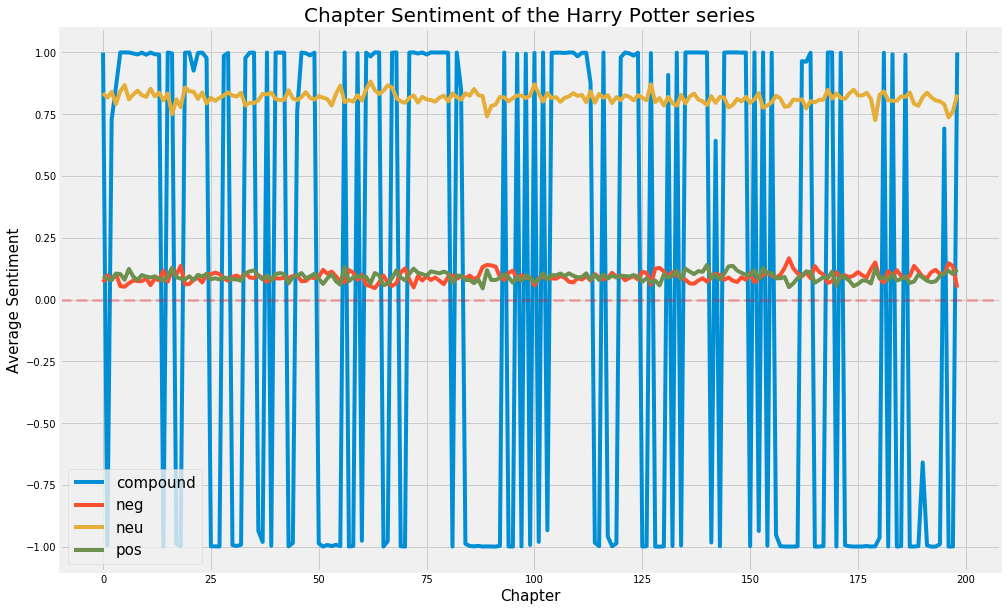

In [19]:
sentiment_scores2 = [[hp2[book][chapter][2][sentiment] for book in hp2 for chapter in hp2[book]]
                     for sentiment in ['compound', 'neg', 'neu', 'pos']]
length = sum([len(hp2[book]) for book in hp2])
x = np.linspace(0, length - 1, num=length)

plt.figure(figsize=(15, 10))
for i, sentiment in enumerate(sentiment_scores2):
    plt.plot(x,
             sentiment,
             label=['compound', 'neg', 'neu', 'pos'][i])
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Chapter Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

In [20]:
compound_sentiment2 = sentiment_scores2[0]
print('Average Book Sentiment:')
print()
for book in book_indices:
    compound = compound_sentiment2[book_indices[book][0]: book_indices[book][1]]
    print('{:45}{:.2f}%'.format(book, 100 * sum(compound) / len(compound)))
print('{:45}{:.2f}%'.format('Across the entire series', 100 * sum(compound_sentiment2) / len(compound_sentiment2)))

Average Book Sentiment:

Harry Potter and the Sorcerer's Stone        73.81%
Harry Potter and the Chamber of Secrets      10.51%
Harry Potter and the Prisoner of Azkaban     -0.57%
Harry Potter and the Goblet of Fire          7.80%
Harry Potter and the Order of the Phoenix    15.46%
Harry Potter and the Half-Blood Prince       12.60%
Harry Potter and the Deathly Hallows         -40.52%
Across the entire series                     5.96%


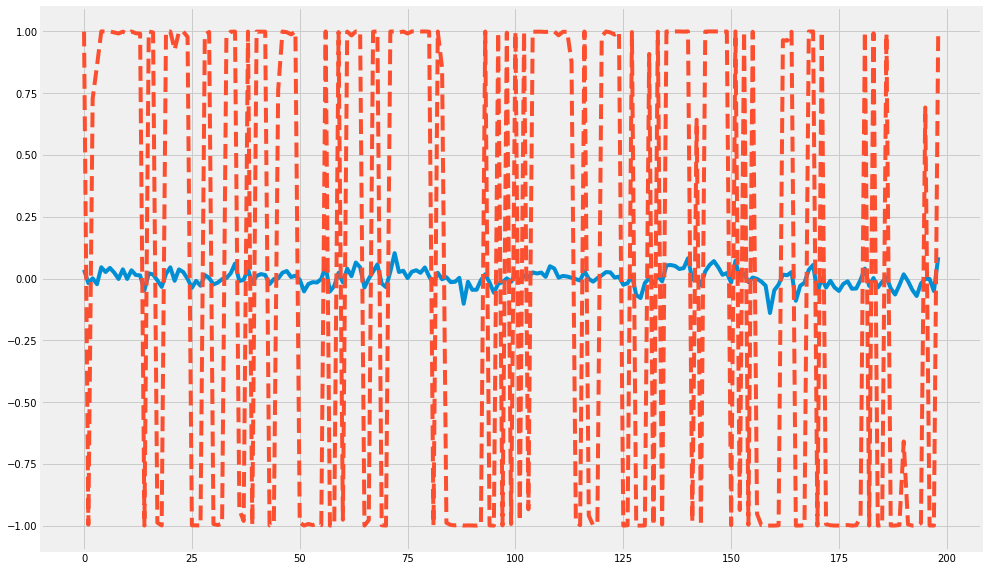

In [21]:
plt.figure(figsize=(15, 10))
plt.plot([hp[book][chapter][2]['compound'] for book in hp for chapter in hp[book]])
plt.plot([hp2[book][chapter][2]['compound'] for book in hp2 for chapter in hp2[book]], linestyle="--")
plt.show()

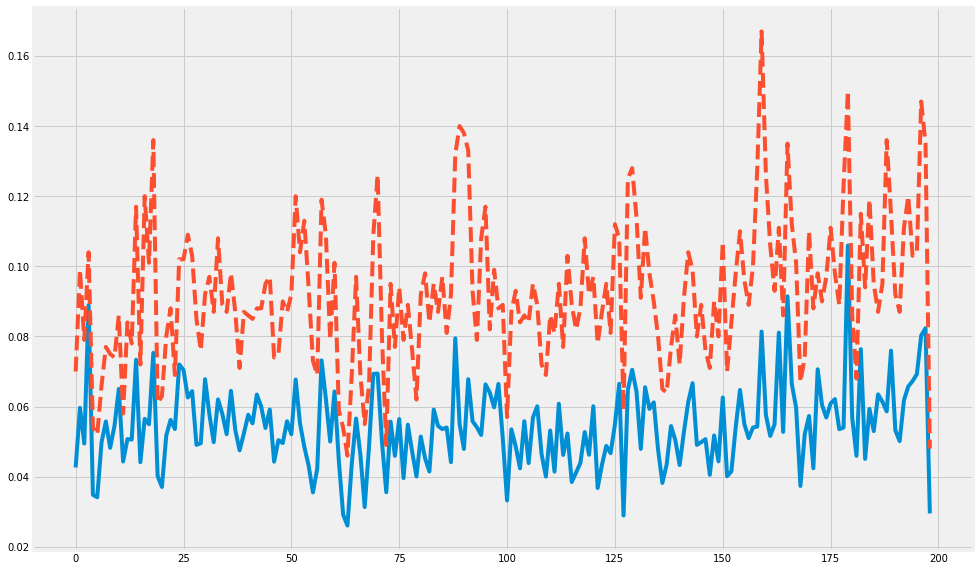

In [22]:
plt.figure(figsize=(15, 10))
plt.plot([hp[book][chapter][2]['neg'] for book in hp for chapter in hp[book]])
plt.plot([hp2[book][chapter][2]['neg'] for book in hp2 for chapter in hp2[book]], linestyle="--")
plt.show()

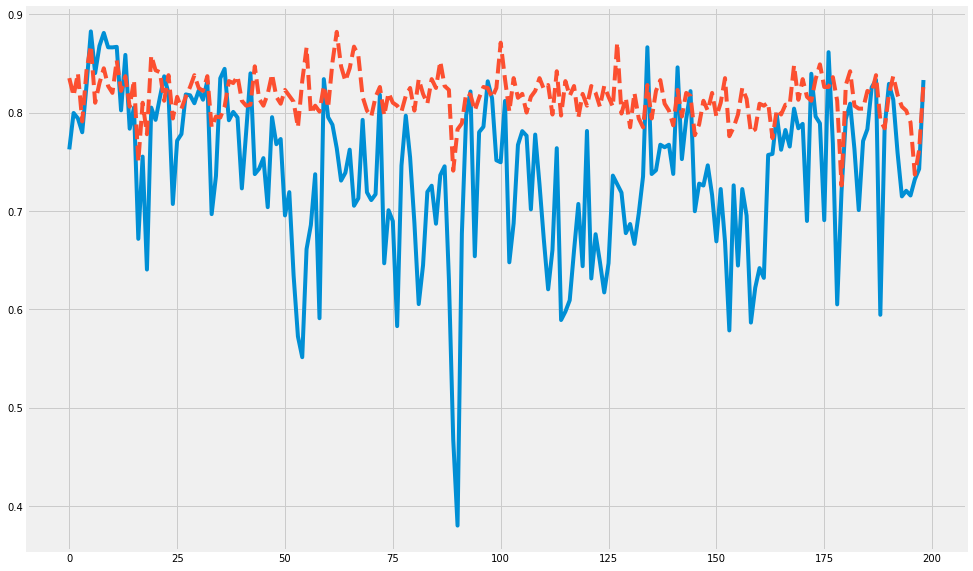

In [23]:
plt.figure(figsize=(15, 10))
plt.plot([hp[book][chapter][2]['neu'] for book in hp for chapter in hp[book]])
plt.plot([hp2[book][chapter][2]['neu'] for book in hp2 for chapter in hp2[book]], linestyle="--")
plt.show()

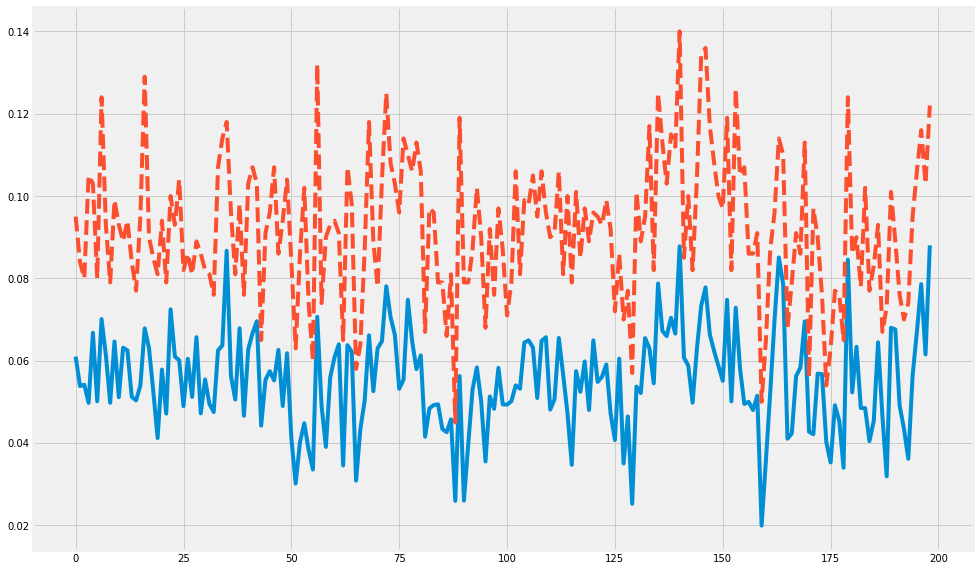

In [24]:
plt.figure(figsize=(15, 10))
plt.plot([hp[book][chapter][2]['pos'] for book in hp for chapter in hp[book]])
plt.plot([hp2[book][chapter][2]['pos'] for book in hp2 for chapter in hp2[book]], linestyle="--")
plt.show()

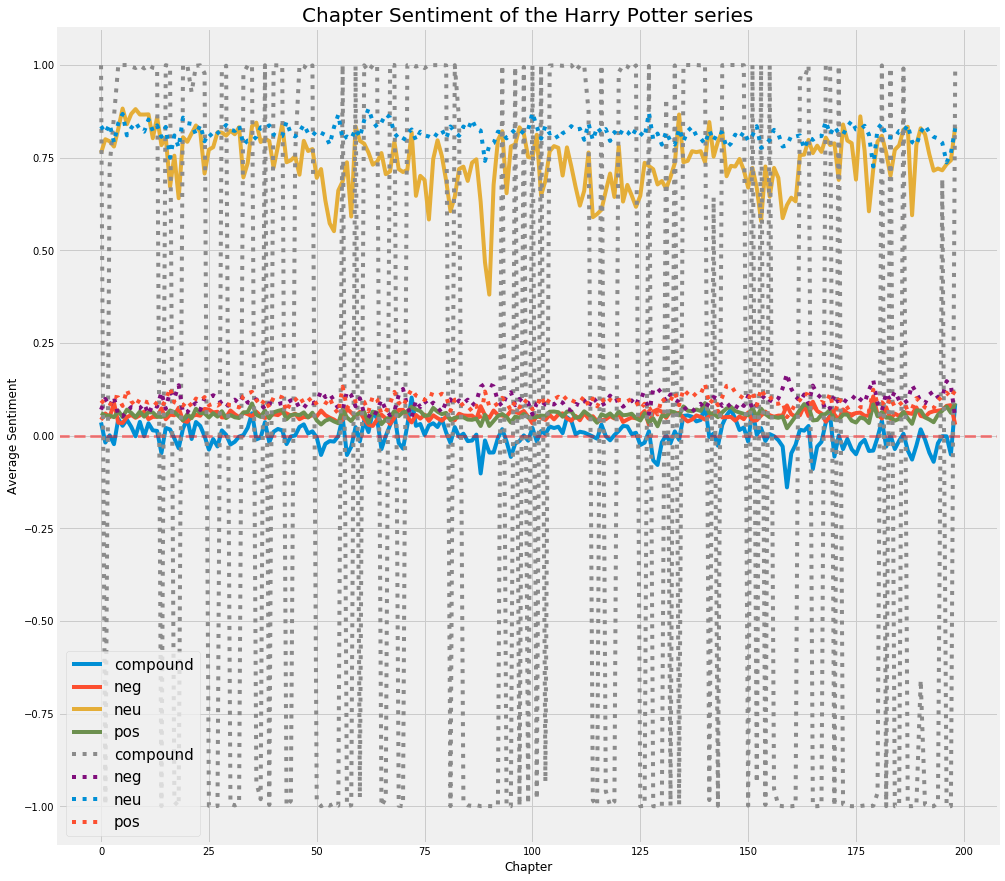

In [25]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)

plt.figure(figsize=(15, 15))
for i, sentiment in enumerate(sentiment_scores):
    plt.plot(x,
             sentiment,
             label=['compound', 'neg', 'neu', 'pos'][i])
# plt.plot(movingaverage(compound_sentiments, 10)+.1, color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)




sentiment_scores2 = [[hp2[book][chapter][2][sentiment] for book in hp2 for chapter in hp2[book]] for sentiment in ['compound', 'neg', 'neu', 'pos']]
length = sum([len(hp2[book]) for book in hp2])
x = np.linspace(0, length - 1, num=length)

for i, sentiment in enumerate(sentiment_scores2):
    plt.plot(x,
             sentiment,
             label=['compound', 'neg', 'neu', 'pos'][i],
             linestyle=':')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Chapter Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter')
plt.ylabel('Average Sentiment')
plt.show()

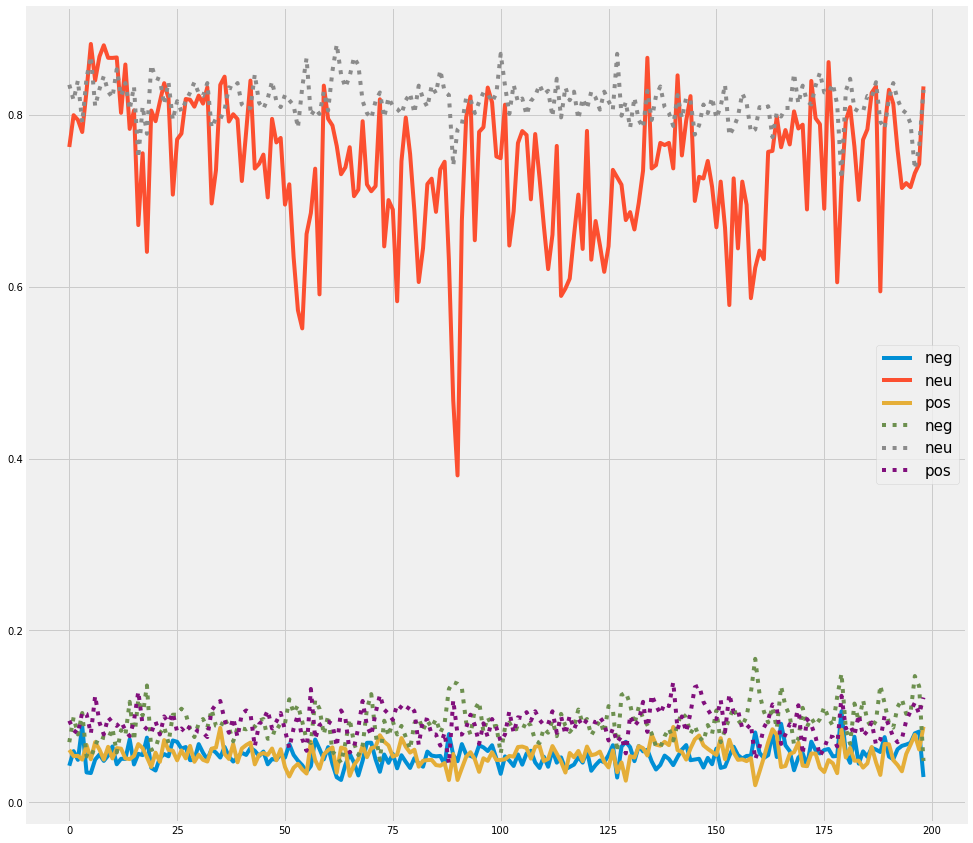

In [26]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)

plt.figure(figsize=(15, 15))
for i, sentiment in enumerate(sentiment_scores[1:]):
    plt.plot(x,
             sentiment,
             label=['neg', 'neu', 'pos'][i])

sentiment_scores2 = [[hp2[book][chapter][2][sentiment] for book in hp2 for chapter in hp2[book]] for sentiment in ['compound', 'neg', 'neu', 'pos']]
length = sum([len(hp2[book]) for book in hp2])
x = np.linspace(0, length - 1, num=length)

for i, sentiment in enumerate(sentiment_scores2[1:]):
    plt.plot(x,
             sentiment,
             label=['neg', 'neu', 'pos'][i],
             linestyle=':')
plt.legend(loc='best', fontsize=15)
plt.show()

# Test TextBlob NaiveBayes and Pattern analyzers

In [27]:
from textblob import Blobber
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.sentiments import PatternAnalyzer

In [28]:
hp3 = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = (f.read().replace('&rsquo;', "'")
                        .replace('&lsquo;', "'")
                        .replace('&rdquo;', '"')
                        .replace('&ldquo;', '"')
                        .replace('&mdash;', '—'))
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = chapter[2][3:]
        phrase = ' HE-WHO-MUST-NOT-BE-NAMED RETURNS'
        if phrase in chap_title:
            chap_title = chap_title.replace(phrase, '')
            chap_text = phrase[1:] + ' I' + chap_text
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull;\s*(CHAPTER [A-Z-]+\s*)|(EPILOGUE)\s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
        hp3[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp3 = dict(hp3)
hp3["Harry Potter and the Deathly Hallows"]['Epilogue'] = hp3["Harry Potter and the Deathly Hallows"].pop('Chapter 37')

In [29]:
nb = Blobber(analyzer=NaiveBayesAnalyzer())

In [30]:
for book in hp3:
    print(book)
    for chapter in tqdm(hp3[book]):
#         print('  ', hp3[book][chapter][0])
        text = hp3[book][chapter][1].replace('\n', '')
        sentence_list = tokenize.sent_tokenize(text)
        sentiments3 = 0
        
        for sentence in sentence_list:
            sentiments3 += nb(sentence).sentiment.p_pos * 2 - 1
            
        sentiments3 = sentiments3 / len(sentence_list)

        hp3[book][chapter] = (hp3[book][chapter][0], hp3[book][chapter][1], sentiments3 )
#     print()

Harry Potter and the Sorcerer's Stone


HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)



Harry Potter and the Chamber of Secrets


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))


Harry Potter and the Prisoner of Azkaban


HBox(children=(IntProgress(value=0, max=22), HTML(value='')))


Harry Potter and the Goblet of Fire


HBox(children=(IntProgress(value=0, max=37), HTML(value='')))


Harry Potter and the Order of the Phoenix


HBox(children=(IntProgress(value=0, max=38), HTML(value='')))


Harry Potter and the Half-Blood Prince


HBox(children=(IntProgress(value=0, max=30), HTML(value='')))


Harry Potter and the Deathly Hallows


HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

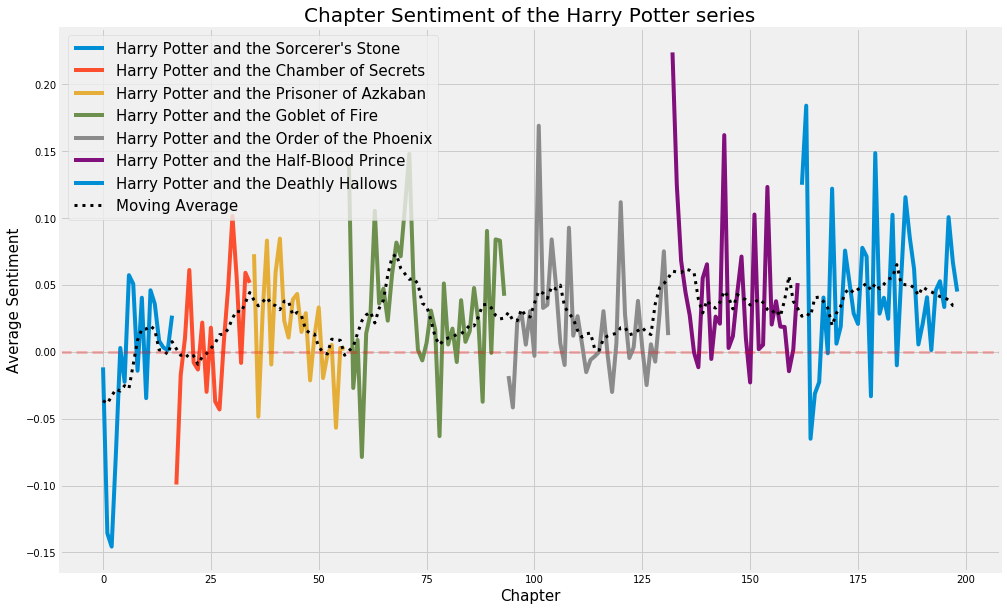

In [31]:
length = sum([len(hp3[book]) for book in hp3])
x = np.linspace(0, length - 1, num=length)
y = [hp3[book][chapter][2] for book in hp3 for chapter in hp3[book]]

plt.figure(figsize=(15, 10))
for book in book_indices:
    plt.plot(x[book_indices[book][0]: book_indices[book][1]],
             y[book_indices[book][0]: book_indices[book][1]],
             label=book)
plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Chapter Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

In [32]:
hp4 = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = (f.read().replace('&rsquo;', "'")
                        .replace('&lsquo;', "'")
                        .replace('&rdquo;', '"')
                        .replace('&ldquo;', '"')
                        .replace('&mdash;', '—'))
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = chapter[2][3:]
        phrase = ' HE-WHO-MUST-NOT-BE-NAMED RETURNS'
        if phrase in chap_title:
            chap_title = chap_title.replace(phrase, '')
            chap_text = phrase[1:] + ' I' + chap_text
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull;\s*(CHAPTER [A-Z-]+\s*)|(EPILOGUE)\s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
        hp4[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp4 = dict(hp4)
hp4["Harry Potter and the Deathly Hallows"]['Epilogue'] = hp4["Harry Potter and the Deathly Hallows"].pop('Chapter 37')

In [33]:
p = Blobber(analyzer=PatternAnalyzer())

In [34]:
for book in hp4:
    print(book)
    for chapter in tqdm(hp4[book]):
#         print('  ', hp4[book][chapter][0])
        text = hp4[book][chapter][1].replace('\n', '')
        sentence_list = tokenize.sent_tokenize(text)
        sentiments4 = 0
        
        for sentence in sentence_list:
            sentiments4 += p(sentence).sentiment.polarity
            
        sentiments4 = sentiments4 / len(sentence_list)

        hp4[book][chapter] = (hp4[book][chapter][0], hp4[book][chapter][1], sentiments4)
#     print()

Harry Potter and the Sorcerer's Stone


HBox(children=(IntProgress(value=0, max=17), HTML(value='')))


Harry Potter and the Chamber of Secrets


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))


Harry Potter and the Prisoner of Azkaban


HBox(children=(IntProgress(value=0, max=22), HTML(value='')))


Harry Potter and the Goblet of Fire


HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)



Harry Potter and the Order of the Phoenix


HBox(children=(IntProgress(value=0, max=38), HTML(value='')))


Harry Potter and the Half-Blood Prince


HBox(children=(IntProgress(value=0, max=30), HTML(value='')))


Harry Potter and the Deathly Hallows


HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

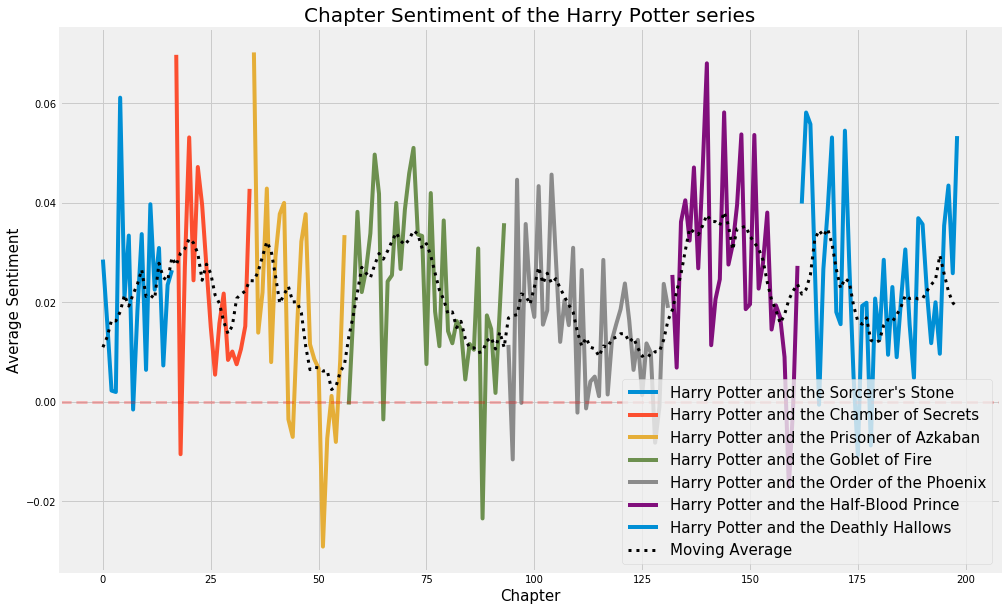

In [35]:
length = sum([len(hp4[book]) for book in hp4])
x = np.linspace(0, length - 1, num=length)
y = [hp4[book][chapter][2] for book in hp4 for chapter in hp4[book]]

plt.figure(figsize=(15, 10))
for book in book_indices:
    plt.plot(x[book_indices[book][0]: book_indices[book][1]],
             y[book_indices[book][0]: book_indices[book][1]],
             label=book)
plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Chapter Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

In [36]:
hp5 = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = (f.read().replace('&rsquo;', "'")
                        .replace('&lsquo;', "'")
                        .replace('&rdquo;', '"')
                        .replace('&ldquo;', '"')
                        .replace('&mdash;', '—'))
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = chapter[2][3:]
        phrase = ' HE-WHO-MUST-NOT-BE-NAMED RETURNS'
        if phrase in chap_title:
            chap_title = chap_title.replace(phrase, '')
            chap_text = phrase[1:] + ' I' + chap_text
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull;\s*(CHAPTER [A-Z-]+\s*)|(EPILOGUE)\s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
        hp5[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp5 = dict(hp5)
hp5["Harry Potter and the Deathly Hallows"]['Epilogue'] = hp5["Harry Potter and the Deathly Hallows"].pop('Chapter 37')

In [37]:
for book in hp5:
    print(book)
    for chapter in tqdm(hp5[book]):
#         print('  ', hp5[book][chapter][0])
        text = hp5[book][chapter][1].replace('\n', '')
        
        sentiment = nb(text).sentiment.p_pos * 2 - 1

        hp5[book][chapter] = (hp5[book][chapter][0], hp5[book][chapter][1], sentiment)
#     print()

Harry Potter and the Sorcerer's Stone


HBox(children=(IntProgress(value=0, max=17), HTML(value='')))


Harry Potter and the Chamber of Secrets


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))


Harry Potter and the Prisoner of Azkaban


HBox(children=(IntProgress(value=0, max=22), HTML(value='')))


Harry Potter and the Goblet of Fire


HBox(children=(IntProgress(value=0, max=37), HTML(value='')))


Harry Potter and the Order of the Phoenix


HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)



Harry Potter and the Half-Blood Prince


HBox(children=(IntProgress(value=0, max=30), HTML(value='')))


Harry Potter and the Deathly Hallows


HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

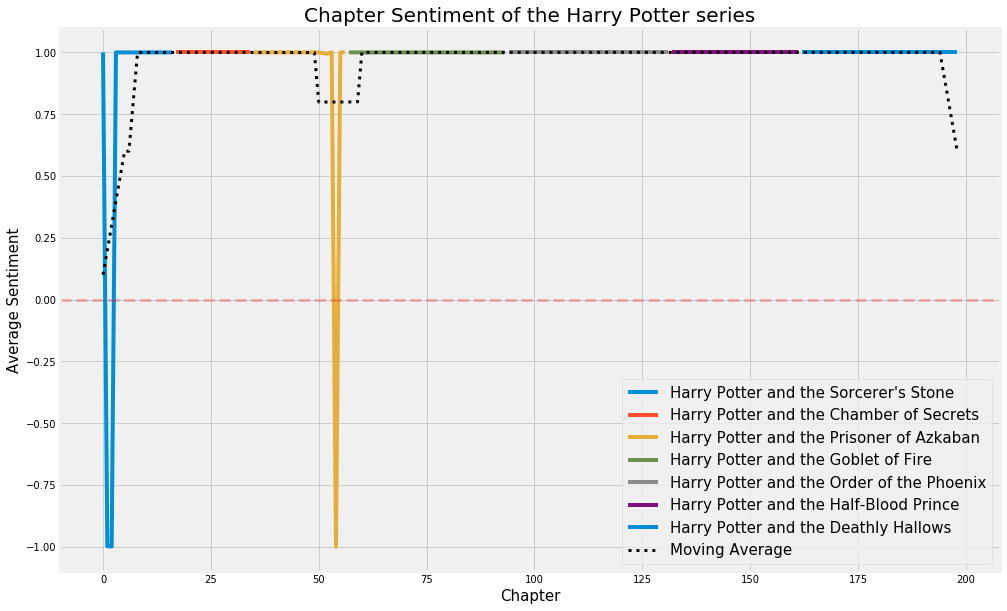

In [38]:
length = sum([len(hp5[book]) for book in hp5])
x = np.linspace(0, length - 1, num=length)
y = [hp5[book][chapter][2] for book in hp5 for chapter in hp5[book]]

plt.figure(figsize=(15, 10))
for book in book_indices:
    plt.plot(x[book_indices[book][0]: book_indices[book][1]],
             y[book_indices[book][0]: book_indices[book][1]],
             label=book)
plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Chapter Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

In [39]:
hp6 = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = (f.read().replace('&rsquo;', "'")
                        .replace('&lsquo;', "'")
                        .replace('&rdquo;', '"')
                        .replace('&ldquo;', '"')
                        .replace('&mdash;', '—'))
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = chapter[2][3:]
        phrase = ' HE-WHO-MUST-NOT-BE-NAMED RETURNS'
        if phrase in chap_title:
            chap_title = chap_title.replace(phrase, '')
            chap_text = phrase[1:] + ' I' + chap_text
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull;\s*(CHAPTER [A-Z-]+\s*)|(EPILOGUE)\s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
        hp6[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp6 = dict(hp6)
hp6["Harry Potter and the Deathly Hallows"]['Epilogue'] = hp6["Harry Potter and the Deathly Hallows"].pop('Chapter 37')

In [40]:
for book in hp6:
    print(book)
    for chapter in tqdm(hp6[book]):
#         print('  ', hp6[book][chapter][0])
        text = hp6[book][chapter][1].replace('\n', '')
        
        sentiment = p(text).sentiment.polarity

        hp6[book][chapter] = (hp6[book][chapter][0], hp6[book][chapter][1], sentiment)
#     print()

Harry Potter and the Sorcerer's Stone


HBox(children=(IntProgress(value=0, max=17), HTML(value='')))


Harry Potter and the Chamber of Secrets


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))


Harry Potter and the Prisoner of Azkaban


HBox(children=(IntProgress(value=0, max=22), HTML(value='')))


Harry Potter and the Goblet of Fire


HBox(children=(IntProgress(value=0, max=37), HTML(value='')))


Harry Potter and the Order of the Phoenix


HBox(children=(IntProgress(value=0, max=38), HTML(value='')))


Harry Potter and the Half-Blood Prince


HBox(children=(IntProgress(value=0, max=30), HTML(value='')))


Harry Potter and the Deathly Hallows


HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

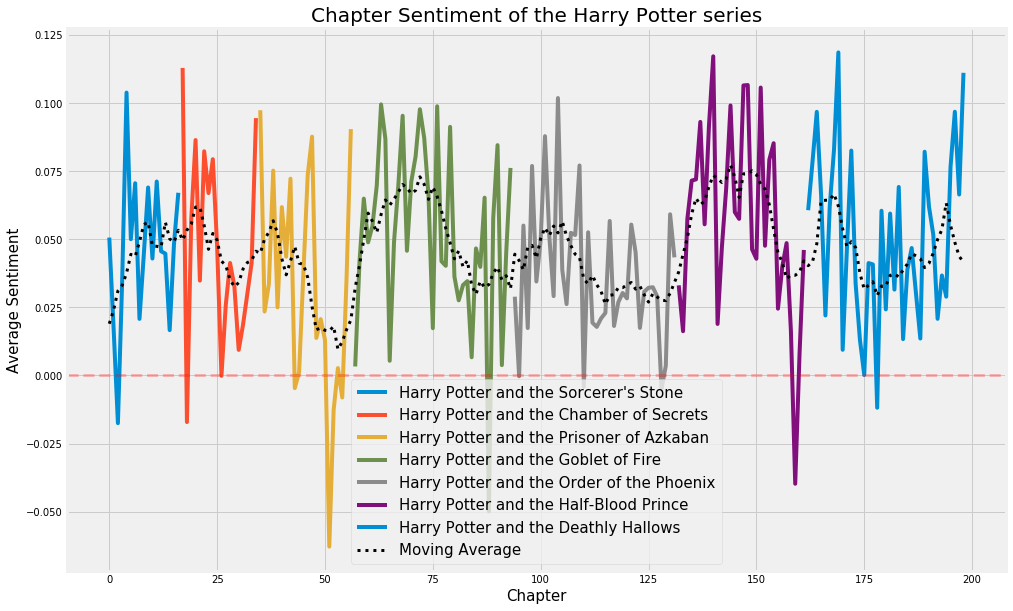

In [41]:
length = sum([len(hp6[book]) for book in hp6])
x = np.linspace(0, length - 1, num=length)
y = [hp6[book][chapter][2] for book in hp6 for chapter in hp6[book]]

plt.figure(figsize=(15, 10))
for book in book_indices:
    plt.plot(x[book_indices[book][0]: book_indices[book][1]],
             y[book_indices[book][0]: book_indices[book][1]],
             label=book)
plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Chapter Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

# NRC emotion lexicon

In [42]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer


def text_emotion(df, column):
    '''
    Takes a DataFrame and a specified column of text and adds 10 columns to the
    DataFrame for each of the 10 emotions in the NRC Emotion Lexicon, with each
    column containing the value of the text in that emotions
    INPUT: DataFrame, string
    OUTPUT: the original DataFrame with ten new columns
    '''

    new_df = df.copy()

    filepath = ('data/'
                'NRC-Sentiment-Emotion-Lexicons/'
                'NRC-Emotion-Lexicon-v0.92/'
                'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t')
    emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=df.index, columns=emotions)

    stemmer = SnowballStemmer("english")

    
    book = ''
    chapter = ''
    
    with tqdm(total=len(list(new_df.iterrows()))) as pbar:
        for i, row in new_df.iterrows():
            pbar.update(1)
            if row['book'] != book:
                print(row['book'])
                book = row['book']
            if row['chapter_title'] != chapter:
                print('   ', row['chapter_title'])
                chapter = row['chapter_title']
                chap = row['chapter_title']
            document = word_tokenize(new_df.loc[i][column])
            for word in document:
                word = stemmer.stem(word.lower())
                emo_score = emolex_words[emolex_words.word == word]
                if not emo_score.empty:
                    for emotion in list(emotions):
                        emo_df.at[i, emotion] += emo_score[emotion]

    new_df = pd.concat([new_df, emo_df], axis=1)

    return new_df

In [43]:
data = {'book': [], 'chapter_title': [], 'text': []}

for book in hp:
    print(book)
    for chapter in tqdm(hp[book]):
        title = hp[book][chapter][0]
#         print('   ', chapter, title)
        text = hp[book][chapter][1].replace('\n', '')
        data['book'].append(book)
        data['chapter_title'].append(title)
        data['text'].append(text)
#     print()
    
hp_df = pd.DataFrame(data=data)

Harry Potter and the Sorcerer's Stone


HBox(children=(IntProgress(value=0, max=17), HTML(value='')))


Harry Potter and the Chamber of Secrets


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))


Harry Potter and the Prisoner of Azkaban


HBox(children=(IntProgress(value=0, max=22), HTML(value='')))


Harry Potter and the Goblet of Fire


HBox(children=(IntProgress(value=0, max=37), HTML(value='')))


Harry Potter and the Order of the Phoenix


HBox(children=(IntProgress(value=0, max=38), HTML(value='')))


Harry Potter and the Half-Blood Prince


HBox(children=(IntProgress(value=0, max=30), HTML(value='')))


Harry Potter and the Deathly Hallows


HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

In [44]:
hp_df = text_emotion(hp_df, 'text')

HBox(children=(IntProgress(value=0, max=199), HTML(value='')))

Harry Potter and the Sorcerer's Stone
    THE BOY WHO LIVED


/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


    THE VANISHING GLASS
    THE LETTERS FROM NO ONE
    THE KEEPER OF THE KEYS
    DIAGON ALLEY
    THE JOURNEY FROM PLATFORM NINE AND THREE-QUARTERS
    THE SORTING HAT
    THE POTIONS MASTER
    THE MIDNIGHT DUEL
    HALLOWEEN
    QUIDDITCH
    THE MIRROR OF ERISED
    NICHOLAS FLAMEL
    NORBERT THE NORWEGIAN RIDGEBACK
    THE FORBIDDEN FOREST
    THROUGH THE TRAPDOOR
    THE MAN WITH TWO FACES
Harry Potter and the Chamber of Secrets
    THE WORST BIRTHDAY
    DOBBY'S WARNING
    THE BURROW
    AT FLOURISH AND BLOTTS
    THE WHOMPING WILLOW
    GILDEROY LOCKHART
    MUDBLOODS AND MURMURS
    THE DEATHDAY PARTY
    THE WRITING ON THE WALL
    THE ROGUE BLUDGER
    THE DUELING CLUB
    THE POLYJUICE POTION
    THE VERY SECRET DIARY
    CORNELIUS FUDGE
    ARAGOG
    THE CHAMBER OF SECRETS
    THE HEIR OF SLYTHERIN
    DOBBY'S REWARD
Harry Potter and the Prisoner of Azkaban
    OWL POST
    AUNT MARGE'S BIG MISTAKE
    THE KNIGHT BUS
    THE LEAKY CAULDRON
    THE DEMENTOR
    TALONS A

In [45]:
hp_df.head()

book            chapter_title  \
0  Harry Potter and the Sorcerer's Stone        THE BOY WHO LIVED   
1  Harry Potter and the Sorcerer's Stone      THE VANISHING GLASS   
2  Harry Potter and the Sorcerer's Stone  THE LETTERS FROM NO ONE   
3  Harry Potter and the Sorcerer's Stone   THE KEEPER OF THE KEYS   
4  Harry Potter and the Sorcerer's Stone             DIAGON ALLEY   

                                                text  anger  anticipation  \
0  Mr. and Mrs. Dursley, of number four, Privet D...     39            87   
1  Nearly ten years had passed since the Dursleys...     58            88   
2  The escape of the Brazilian boa constrictor ea...     67           117   
3  BOOM. They knocked again. Dudley jerked awake....     61            84   
4  Harry woke early the next morning. Although he...     69           151   

   disgust  fear  joy  negative  positive  sadness  surprise  trust  
0       29    59   56       131       156       52        56    127  
1       66    90   55       152       125       68        67    102  
2       42    53   40       123       117       53        42     88  
3       43   111   37       156       119       70        70     78  
4       81    88   83       179       245       68        84    154

In [46]:
hp_df['word_count'] = hp_df['text'].apply(tokenize.word_tokenize).apply(len)

In [47]:
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']

In [48]:
for emotion in emotions:
    hp_df[emotion] = hp_df[emotion] / hp_df['word_count']

In [49]:
hp_df.set_index(['book', 'chapter_title'], inplace=True)

In [50]:
hp_df.head()

text  \
book                                  chapter_title                                                                
Harry Potter and the Sorcerer's Stone THE BOY WHO LIVED        Mr. and Mrs. Dursley, of number four, Privet D...   
                                      THE VANISHING GLASS      Nearly ten years had passed since the Dursleys...   
                                      THE LETTERS FROM NO ONE  The escape of the Brazilian boa constrictor ea...   
                                      THE KEEPER OF THE KEYS   BOOM. They knocked again. Dudley jerked awake....   
                                      DIAGON ALLEY             Harry woke early the next morning. Although he...   

                                                                  anger  \
book                                  chapter_title                       
Harry Potter and the Sorcerer's Stone THE BOY WHO LIVED        0.006786   
                                      THE VANISHING GLASS      0.013738   
                                      THE LETTERS FROM NO ONE  0.014153   
                                      THE KEEPER OF THE KEYS   0.012528   
                                      DIAGON ALLEY             0.008068   

                                                               anticipation  \
book                                  chapter_title                           
Harry Potter and the Sorcerer's Stone THE BOY WHO LIVED            0.015138   
                                      THE VANISHING GLASS          0.020843   
                                      THE LETTERS FROM NO ONE      0.024715   
                                      THE KEEPER OF THE KEYS       0.017252   
                                      DIAGON ALLEY                 0.017657   

                                                                disgust  \
book                                  chapter_title                       
Harry Potter and the Sorcerer's Stone THE BOY WHO LIVED        0.005046   
                                      THE VANISHING GLASS      0.015632   
                                      THE LETTERS FROM NO ONE  0.008872   
                                      THE KEEPER OF THE KEYS   0.008831   
                                      DIAGON ALLEY             0.009471   

                                                                   fear  \
book                                  chapter_title                       
Harry Potter and the Sorcerer's Stone THE BOY WHO LIVED        0.010266   
                                      THE VANISHING GLASS      0.021317   
                                      THE LETTERS FROM NO ONE  0.011196   
                                      THE KEEPER OF THE KEYS   0.022797   
                                      DIAGON ALLEY             0.010290   

                                                                    joy  \
book                                  chapter_title                       
Harry Potter and the Sorcerer's Stone THE BOY WHO LIVED        0.009744   
                                      THE VANISHING GLASS      0.013027   
                                      THE LETTERS FROM NO ONE  0.008450   
                                      THE KEEPER OF THE KEYS   0.007599   
                                      DIAGON ALLEY             0.009705   

                                                               negative  \
book                                  chapter_title                       
Harry Potter and the Sorcerer's Stone THE BOY WHO LIVED        0.022795   
                                      THE VANISHING GLASS      0.036002   
                                      THE LETTERS FROM NO ONE  0.025982   
                                      THE KEEPER OF THE KEYS   0.032039   
                                      DIAGON ALLEY             0.020931   

                                                               positive  \
book                                

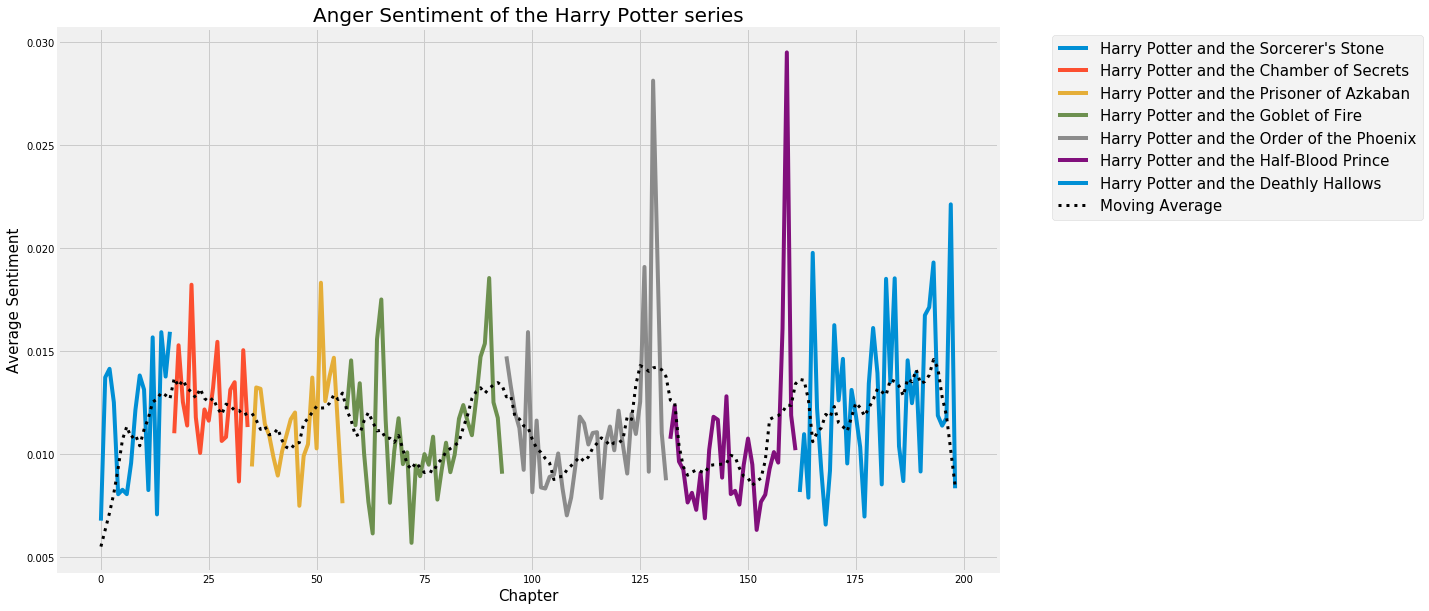

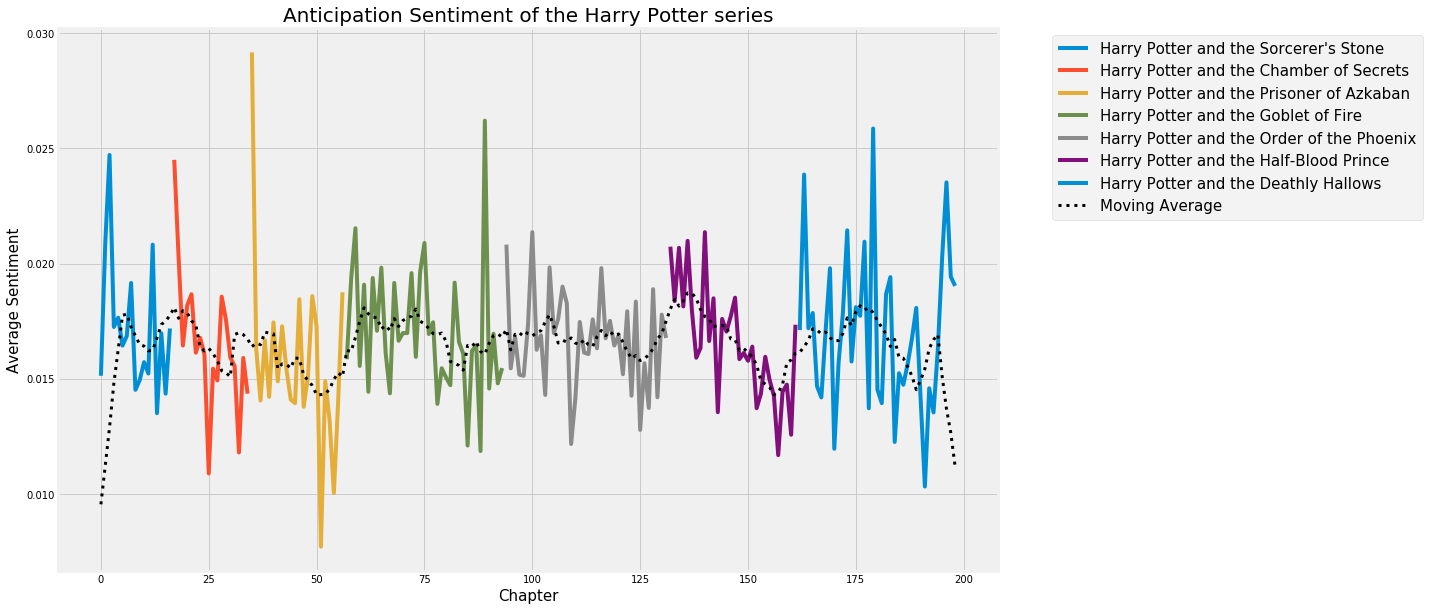

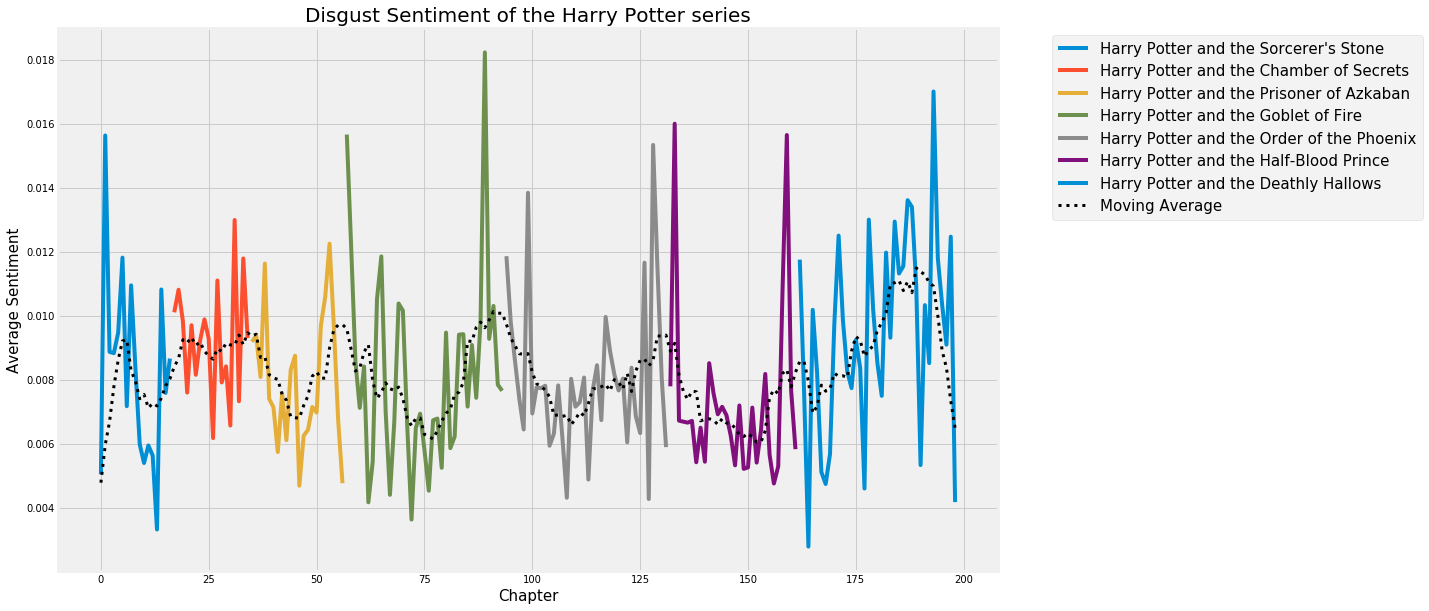

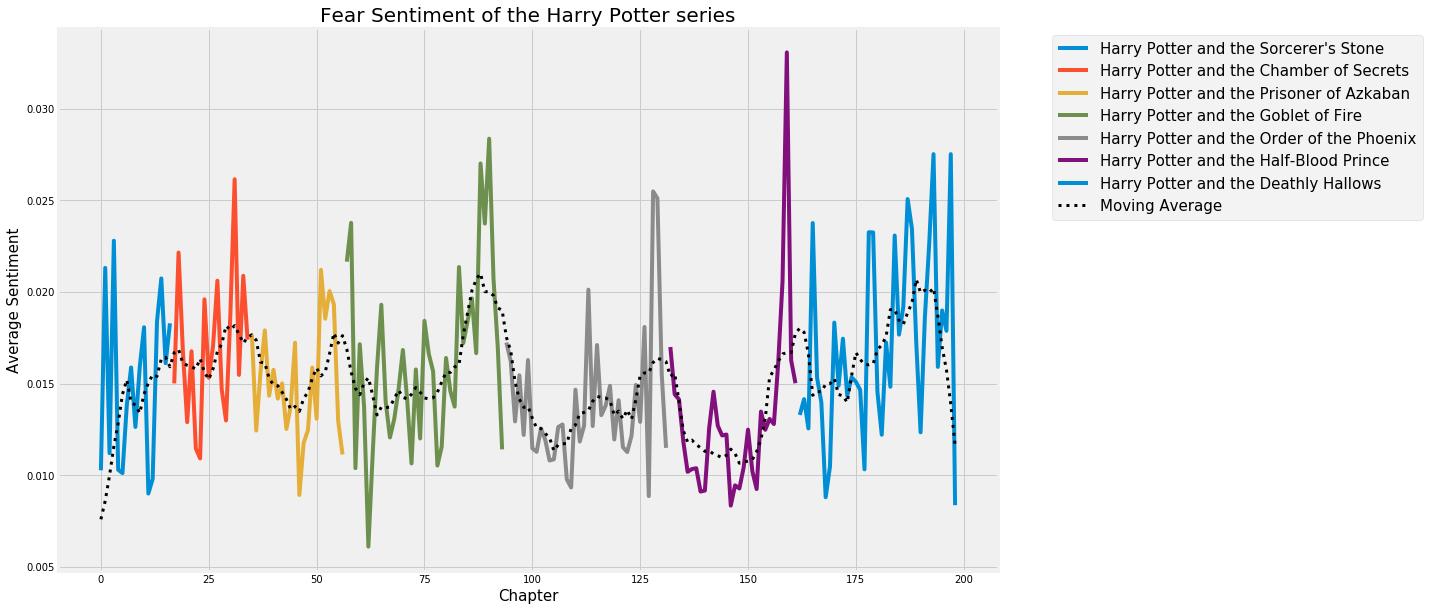

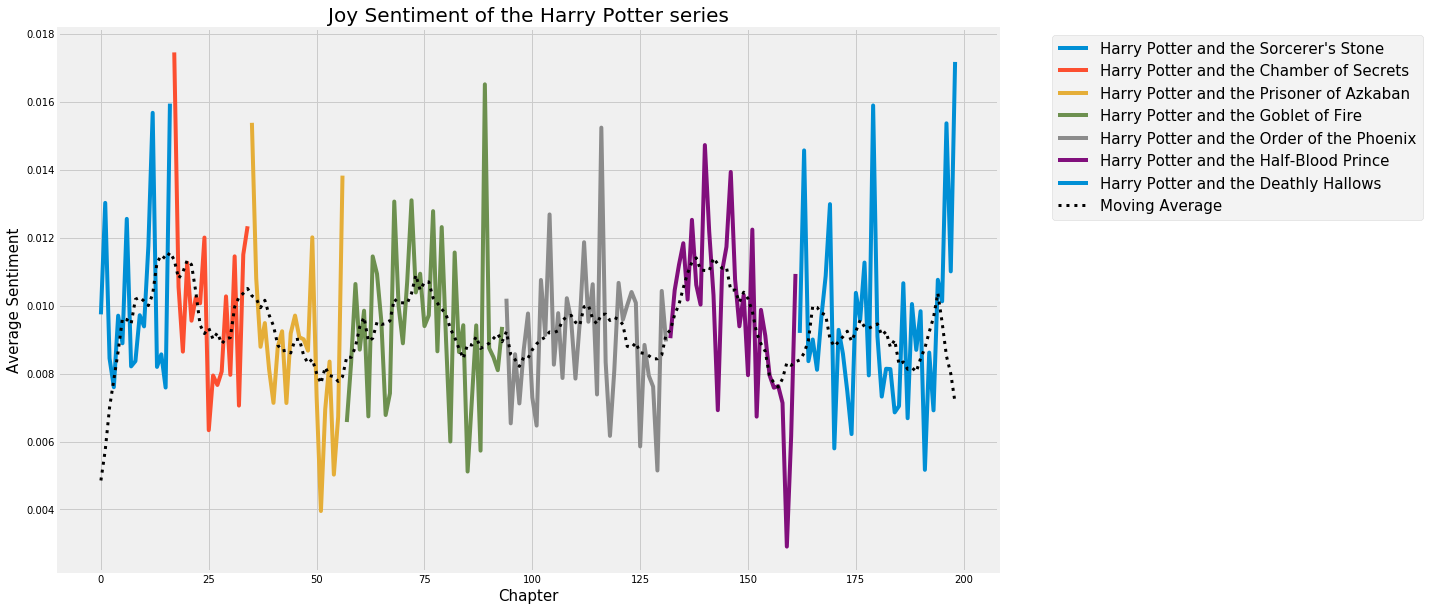

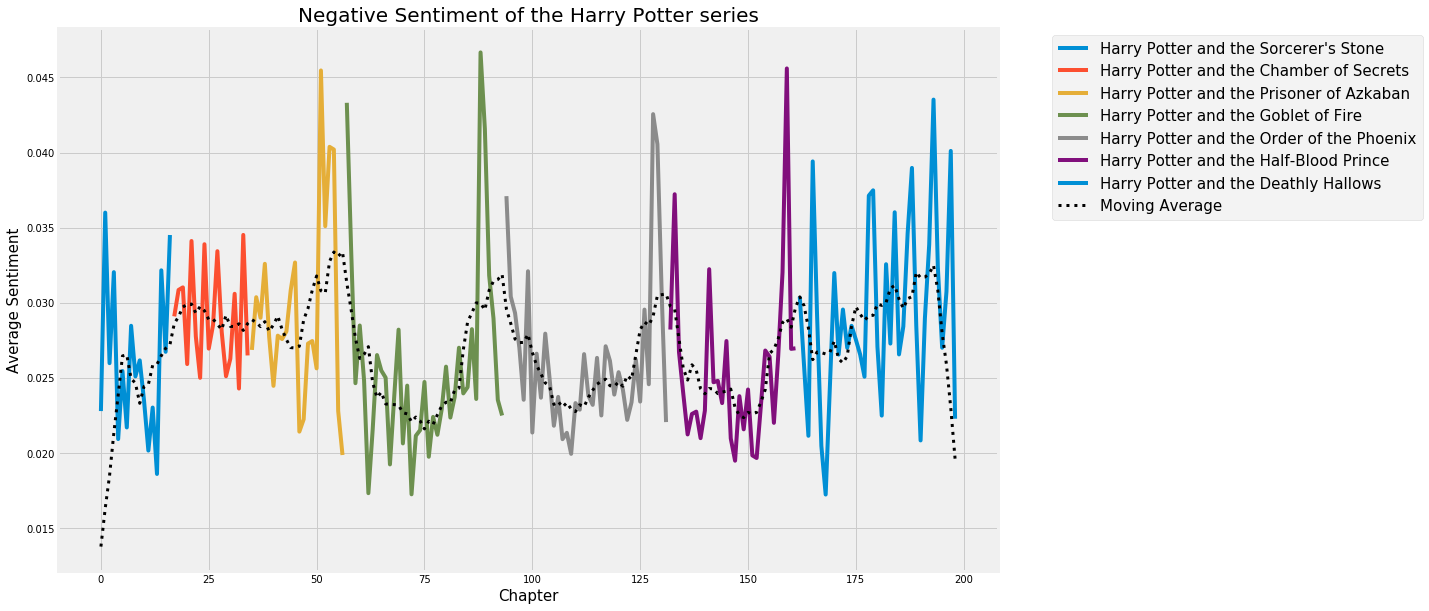

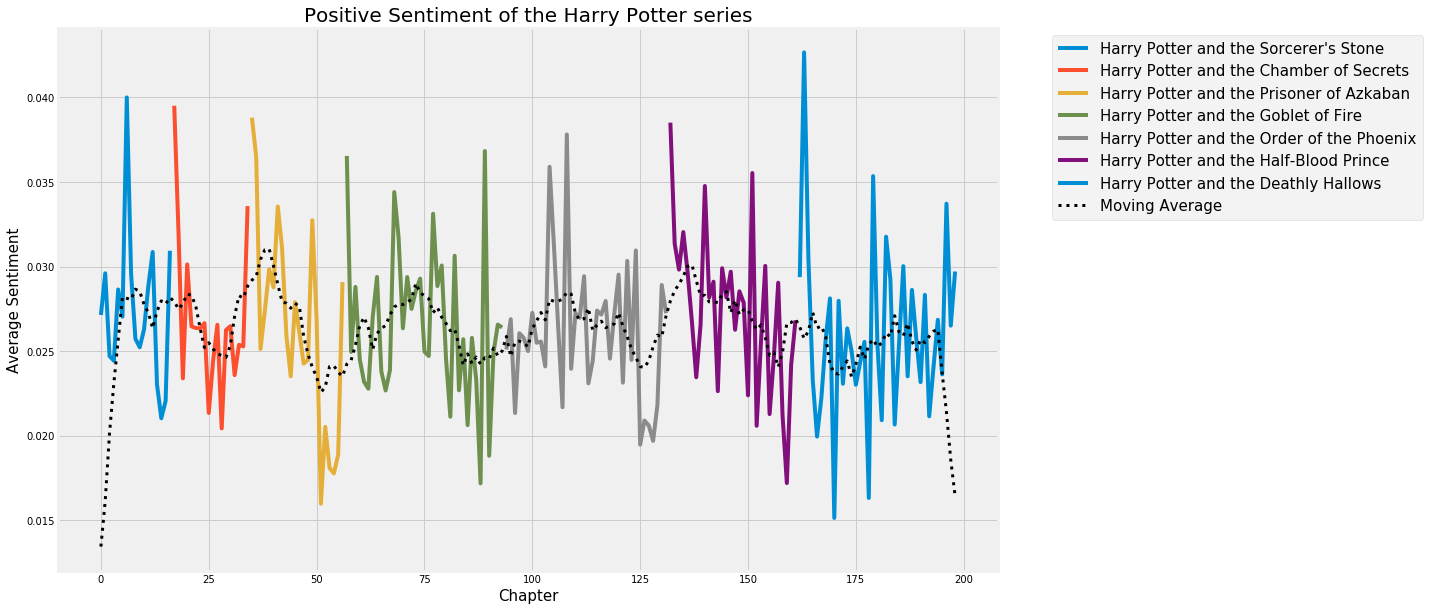

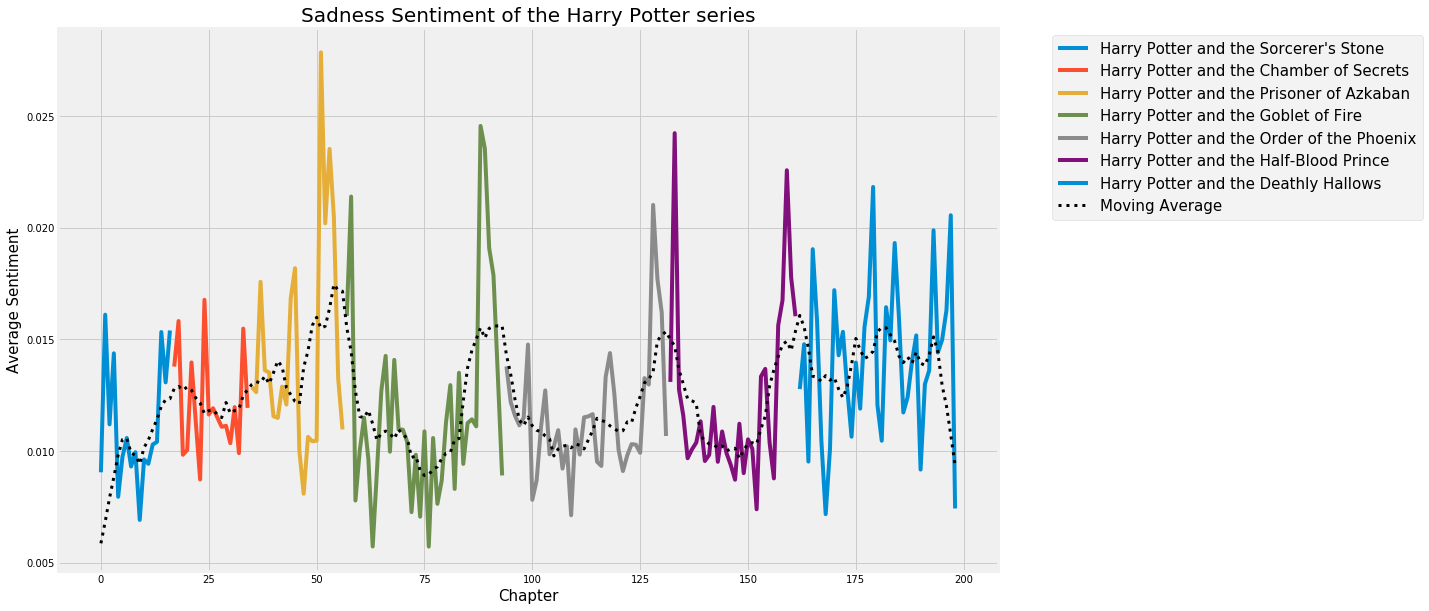

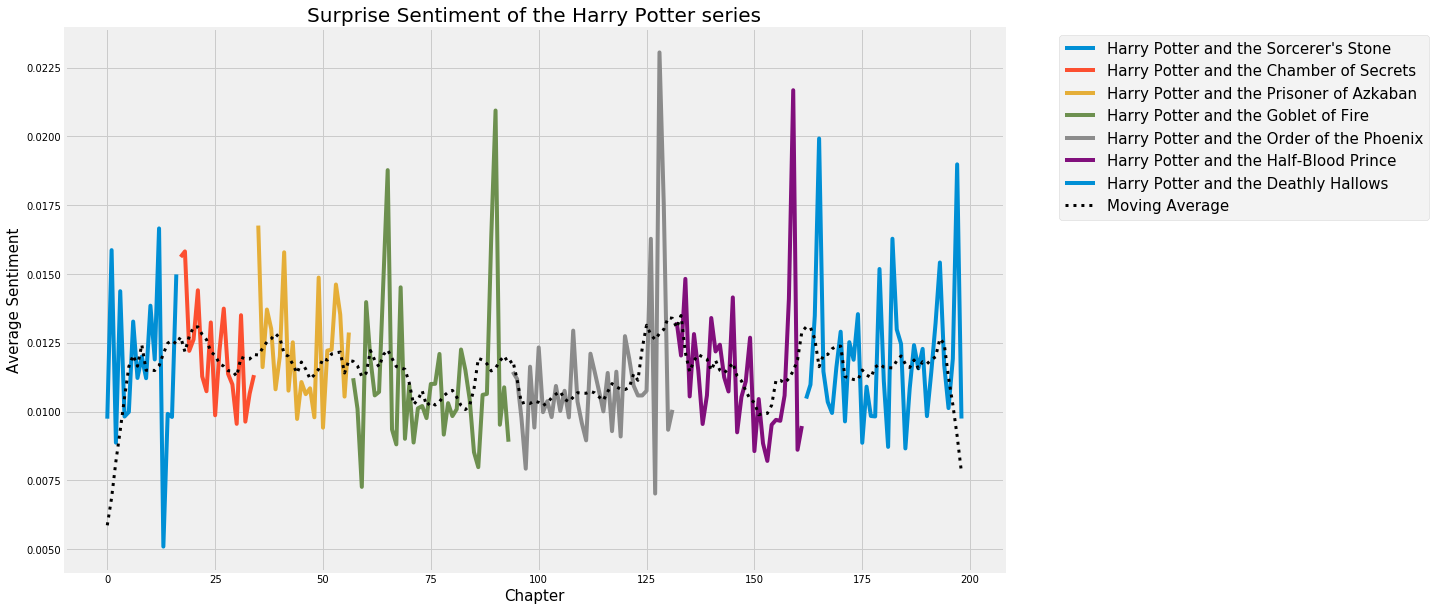

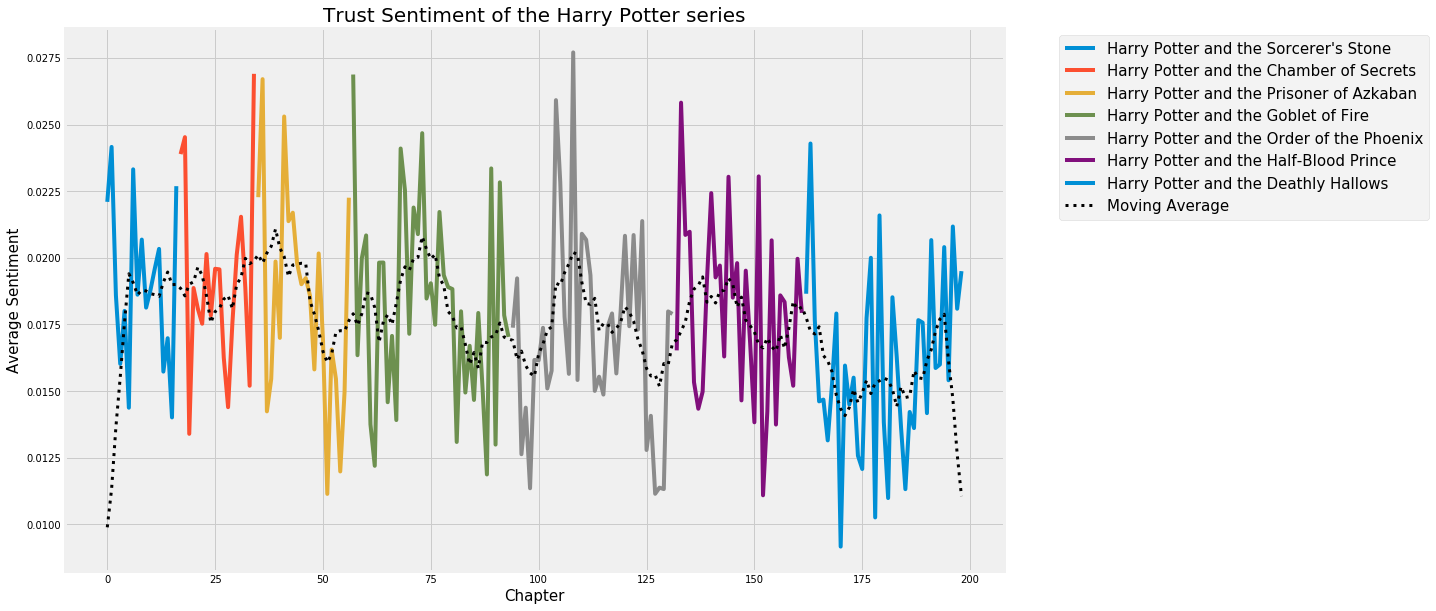

In [51]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)

for emotion in emotions:
    y = [hp_df.loc[book].loc[hp[book][chapter][0]][emotion] for book in hp for chapter in hp[book]]

    plt.figure(figsize=(15, 10))
    for book in book_indices:
        plt.plot(x[book_indices[book][0]: book_indices[book][1]],
                 y[book_indices[book][0]: book_indices[book][1]],
                 label=book)
    plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label='Moving Average')
    plt.legend(loc='best', fontsize=15, bbox_to_anchor=(1.05, 1))
    plt.title('{} Sentiment of the Harry Potter series'.format(emotion.title()), fontsize=20)
    plt.xlabel('Chapter', fontsize=15)
    plt.ylabel('Average Sentiment', fontsize=15)
    plt.show()

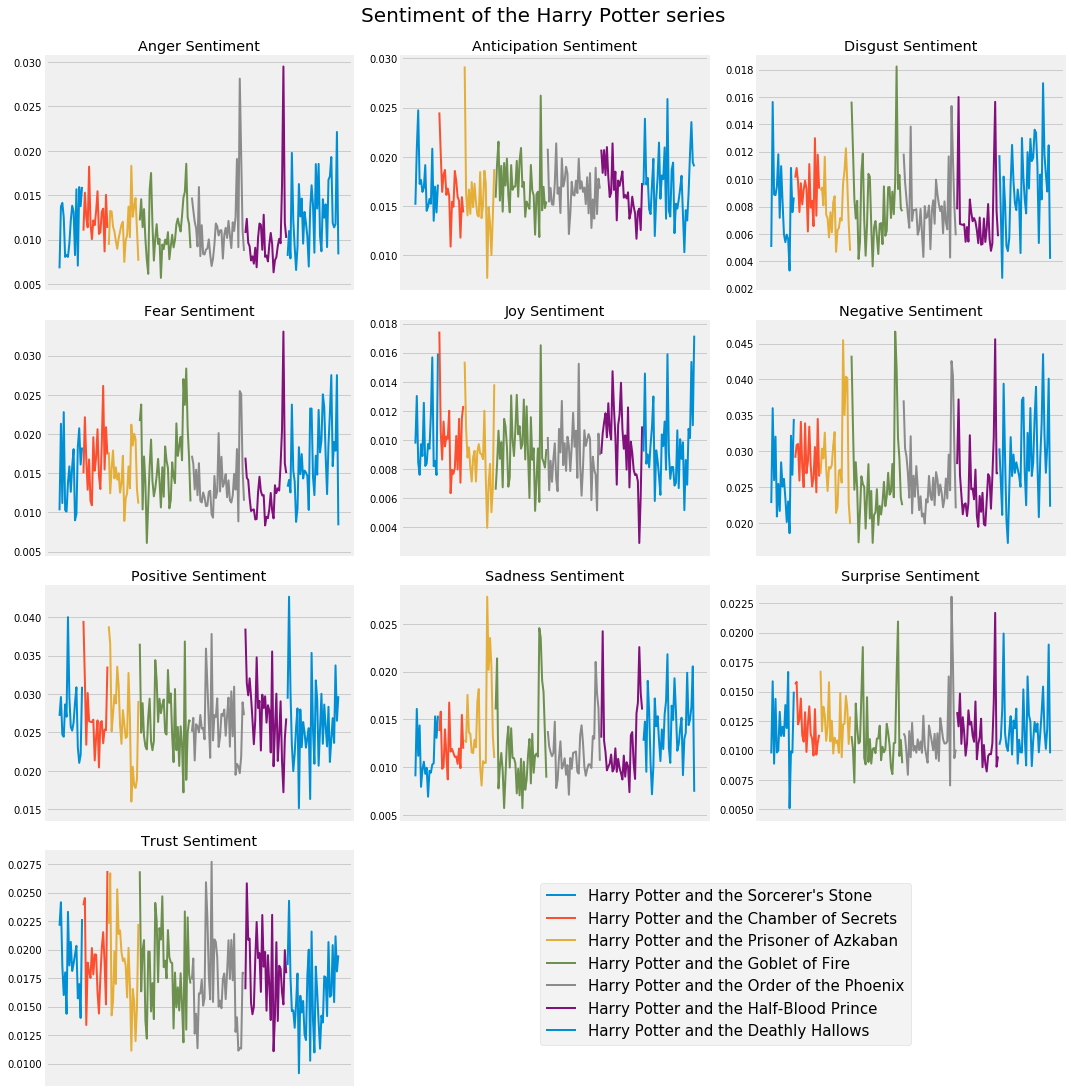

In [52]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)

fig, ax = plt.subplots(4, 3, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)
fig.suptitle('Sentiment of the Harry Potter series', fontsize=20, y=1.02)
fig.subplots_adjust(top=0.88)

ax = ax.ravel()

for i, emotion in enumerate(emotions):
    y = [hp_df.loc[book].loc[hp[book][chapter][0]][emotion] for book in hp for chapter in hp[book]]
    for book in book_indices:
        ax[i].plot(x[book_indices[book][0]: book_indices[book][1]],
                 y[book_indices[book][0]: book_indices[book][1]],
                 label=book, linewidth=2)

    ax[i].set_title('{} Sentiment'.format(emotion.title()))
    ax[i].set_xticks([])

fig.legend(list(hp), loc='upper right', fontsize=15, bbox_to_anchor=(.85, .2))
fig.tight_layout()
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])
plt.show()

In [53]:
tab10 = matplotlib.cm.get_cmap('tab10')

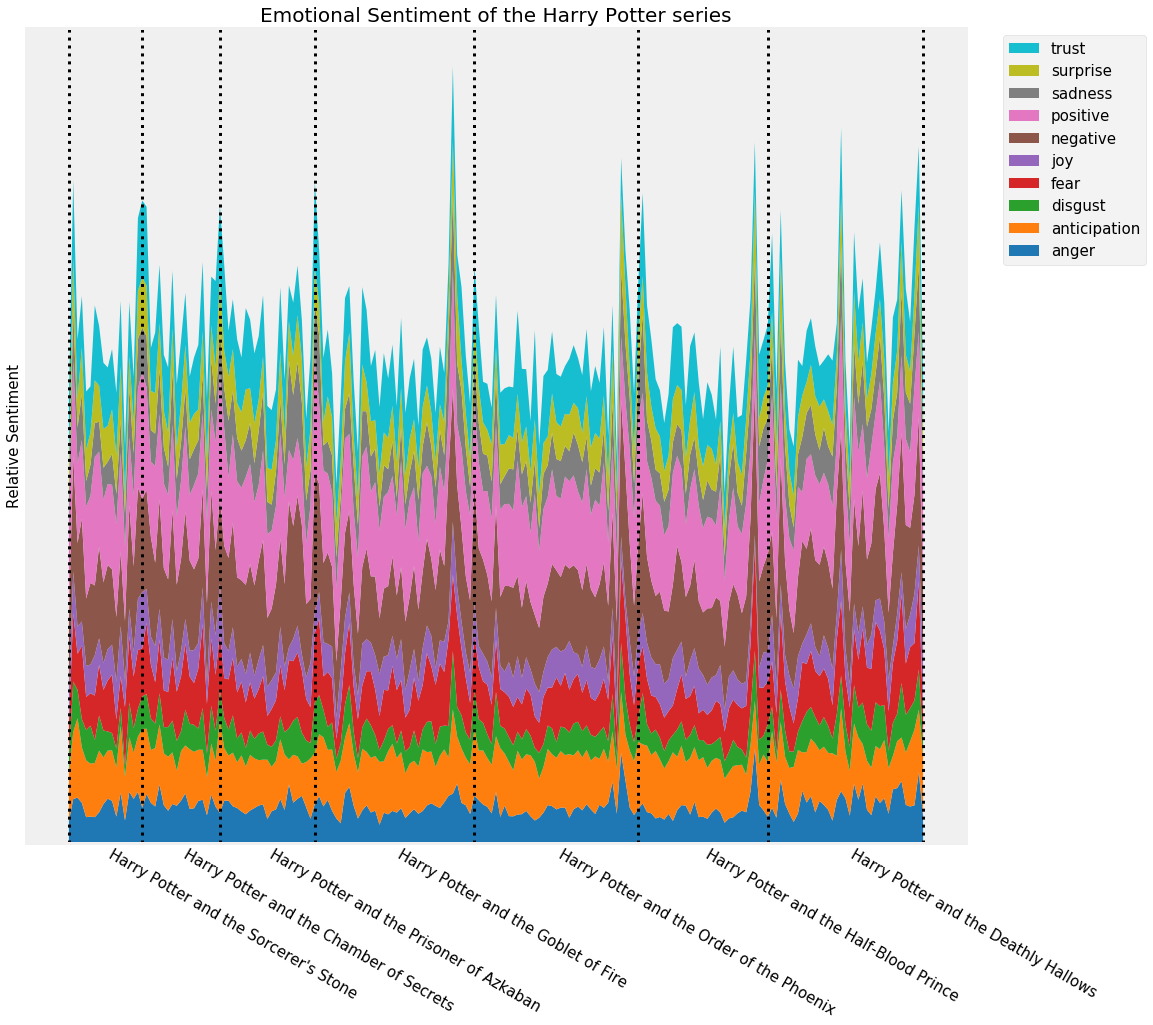

In [71]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)


y = [hp_df[emotion].tolist() for emotion in emotions]
plt.stackplot(x, y, colors=(tab10(0),
                            tab10(.1),
                            tab10(.2),
                            tab10(.3),
                            tab10(.4),
                            tab10(.5),
                            tab10(.6),
                            tab10(.7),
                            tab10(.8),
                            tab10(.9)), labels=emotions)
# Plot vertical lines marking the books
for book in book_indices:
    plt.axvline(x=book_indices[book][0], color='black', linewidth=3, linestyle=':')
plt.axvline(x=book_indices[book][1]-1, color='black', linewidth=3, linestyle=':')

plt.title('Emotional Sentiment of the Harry Potter series', fontsize=20)
plt.xticks([(book_indices[book][0] + book_indices[book][1]) / 2 for book in book_indices],
           list(hp),
           rotation=-30,
           fontsize=15,
           ha='left')
plt.yticks([])
plt.ylabel('Relative Sentiment', fontsize=15)

# Reverse the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))

ax.grid(False)

plt.show()

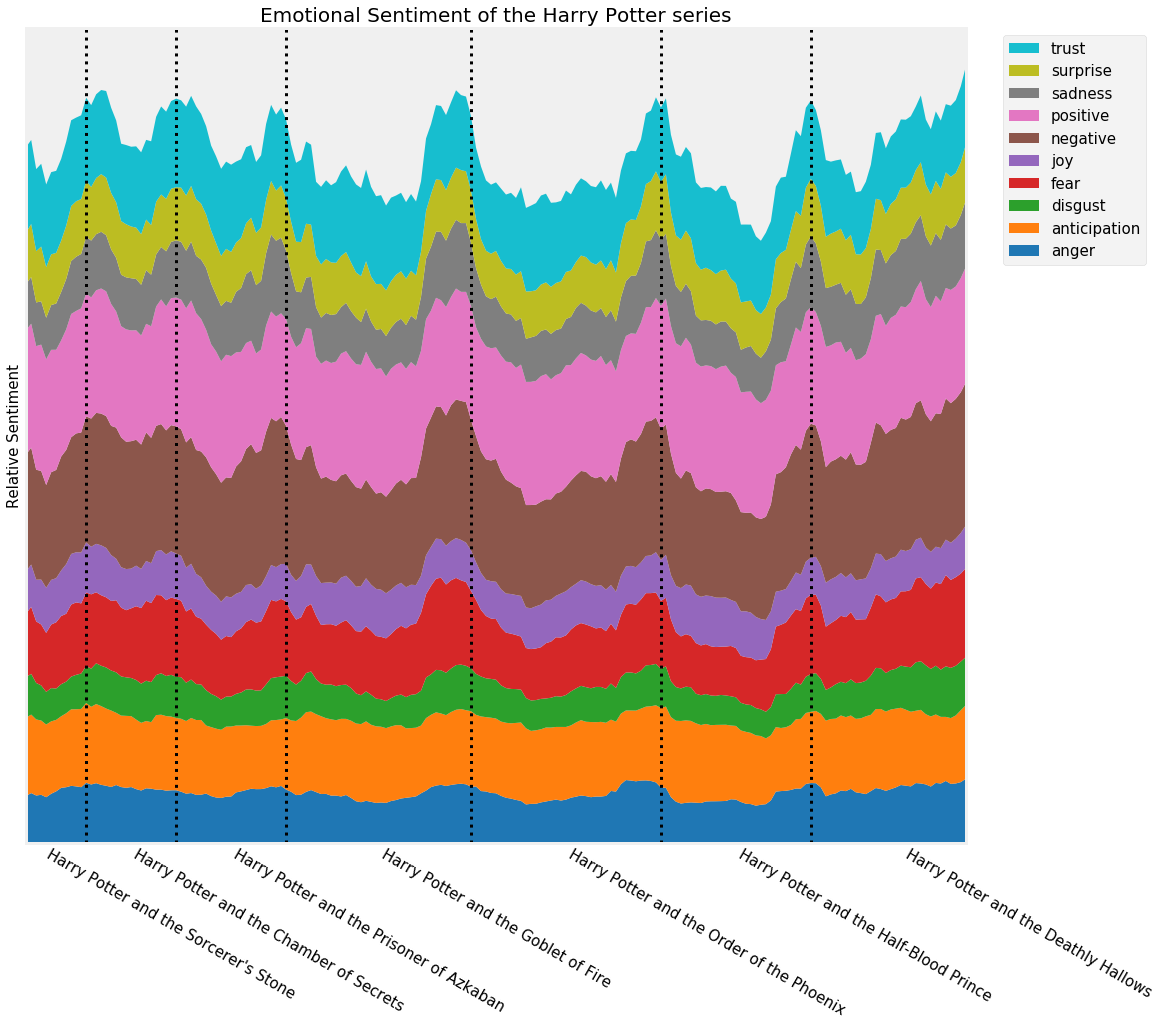

In [72]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)
window = 10

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)


y = [movingaverage(hp_df[emotion].tolist(), window) for emotion in emotions]

plt.stackplot(x, y, colors=(tab10(0),
                            tab10(.1),
                            tab10(.2),
                            tab10(.3),
                            tab10(.4),
                            tab10(.5),
                            tab10(.6),
                            tab10(.7),
                            tab10(.8),
                            tab10(.9)), labels=emotions)
# Plot vertical lines marking the books
for book in book_indices:
    plt.axvline(x=book_indices[book][0], color='black', linewidth=3, linestyle=':')
plt.axvline(x=book_indices[book][1]-1, color='black', linewidth=3, linestyle=':')

plt.title('Emotional Sentiment of the Harry Potter series', fontsize=20)
plt.xticks([(book_indices[book][0] + book_indices[book][1]) / 2 for book in book_indices],
           list(hp),
           rotation=-30,
           fontsize=15,
           ha='left')
plt.yticks([])
plt.ylabel('Relative Sentiment', fontsize=15)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))

axes = plt.gca()
axes.set_xlim([min(x) + window / 2, max(x) - window / 2])

ax.grid(False)

plt.show()

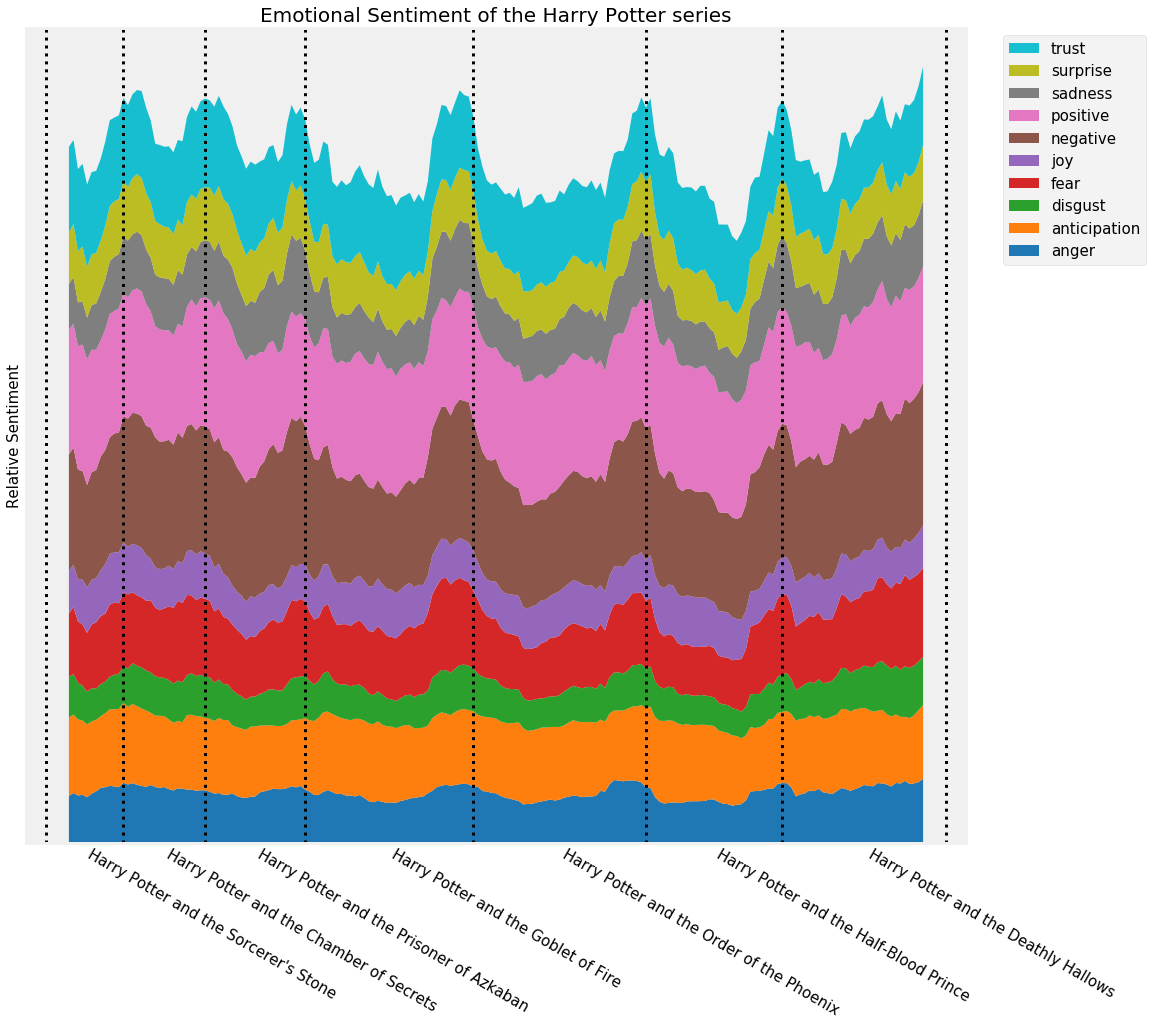

In [73]:
length = sum([len(hp[book]) for book in hp])
window = 10
x = np.linspace(0, length - 1, num=length)[int(window / 2): -int(window / 2)]

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)

y = [movingaverage(hp_df[emotion].tolist(), window)[int(window / 2): -int(window / 2)] for emotion in emotions]

plt.stackplot(x, y, colors=(tab10(0),
                            tab10(.1),
                            tab10(.2),
                            tab10(.3),
                            tab10(.4),
                            tab10(.5),
                            tab10(.6),
                            tab10(.7),
                            tab10(.8),
                            tab10(.9)), labels=emotions)
# Plot vertical lines marking the books
for book in book_indices:
    plt.axvline(x=book_indices[book][0], color='black', linewidth=3, linestyle=':')
plt.axvline(x=book_indices[book][1]-1, color='black', linewidth=3, linestyle=':')

plt.title('Emotional Sentiment of the Harry Potter series', fontsize=20)
plt.xticks([(book_indices[book][0] + book_indices[book][1]) / 2 for book in book_indices],
           list(hp),
           rotation=-30,
           fontsize=15,
           ha='left')
plt.yticks([])
plt.ylabel('Relative Sentiment', fontsize=15)

# Reverse the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))

ax.grid(False)

plt.show()

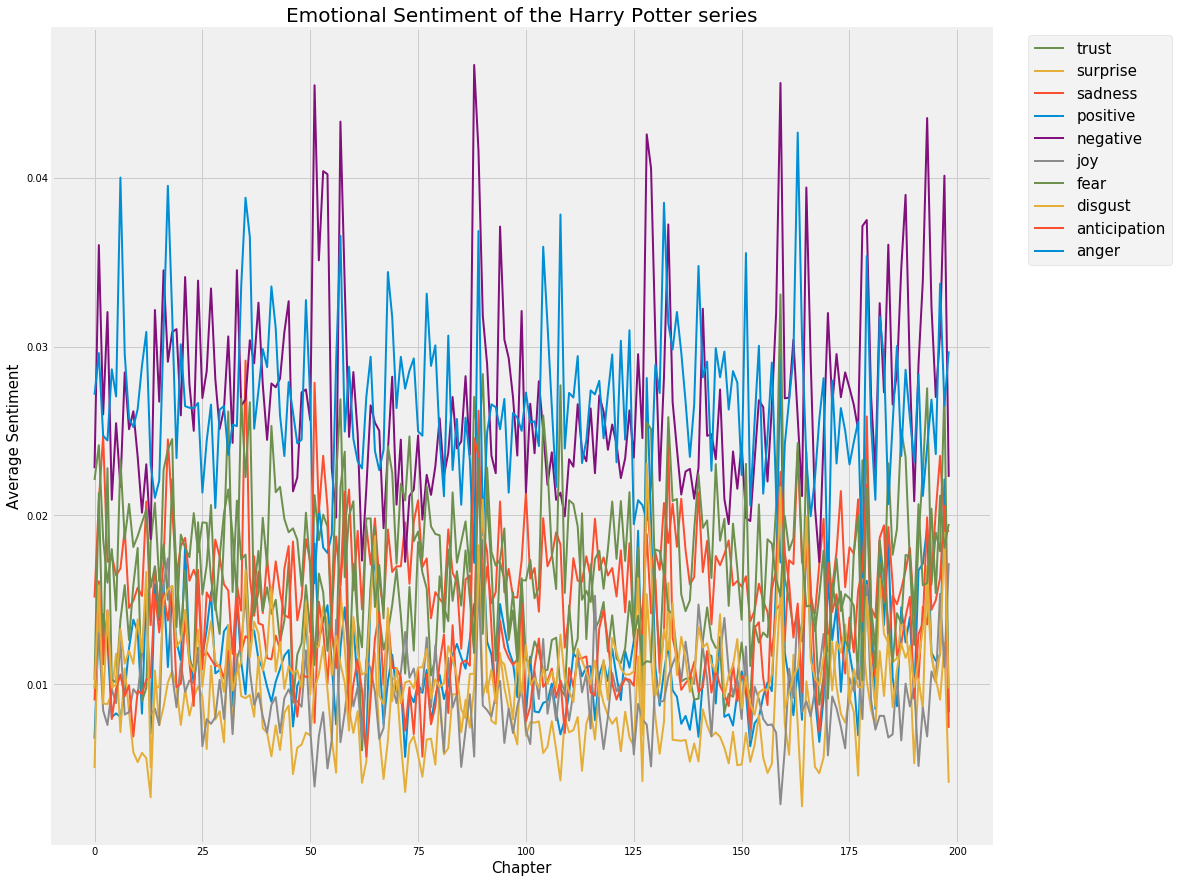

In [57]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)

fig = plt.figure(figsize=(15, 15))
ax =fig.add_subplot(1, 1, 1)

for emotion in emotions:
    y = [hp_df.loc[book].loc[hp[book][chapter][0]][emotion] for book in hp for chapter in hp[book]]
    plt.plot(x, y, linewidth=2, label=emotion)
# plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.show()

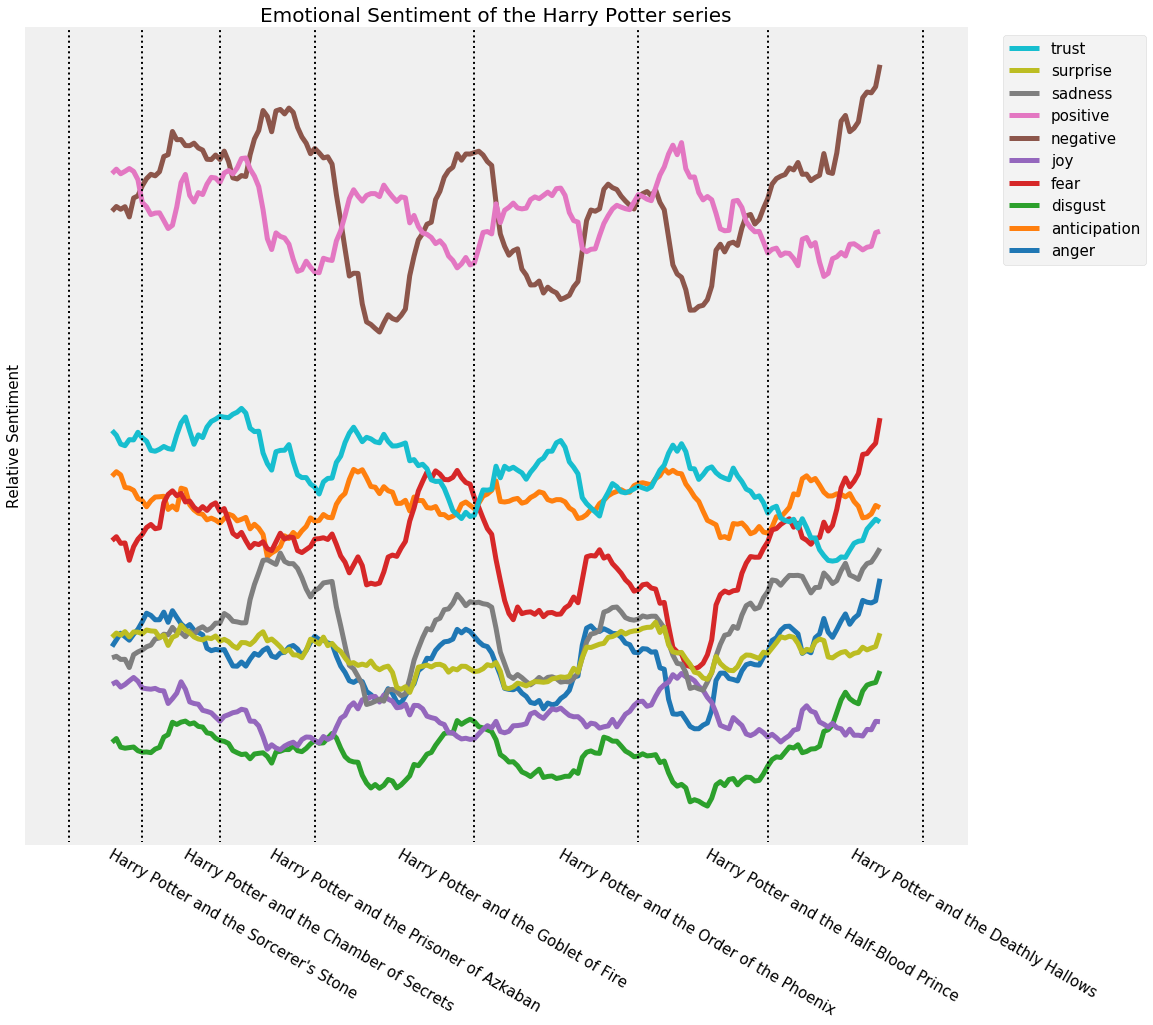

In [74]:
length = sum([len(hp[book]) for book in hp])
window = 20
x = np.linspace(0, length - 1, num=length)[int(window / 2): -int(window / 2)]

fig = plt.figure(figsize=(15, 15))
ax =fig.add_subplot(1, 1, 1)

for c, emotion in enumerate(emotions):
    y = movingaverage([hp_df.loc[book].loc[hp[book][chapter][0]][emotion] for
                       book in hp for chapter in hp[book]], window)[int(window / 2): -int(window / 2)]
    plt.plot(x, y, linewidth=5, label=emotion, color=(tab10(c)))
    
# Plot vertical lines marking the books
for book in book_indices:
    plt.axvline(x=book_indices[book][0], color='black', linewidth=2, linestyle=':')
plt.axvline(x=book_indices[book][1]-1, color='black', linewidth=2, linestyle=':')

plt.legend(loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of the Harry Potter series', fontsize=20)
plt.ylabel('Relative Sentiment', fontsize=15)
plt.xticks([(book_indices[book][0] + book_indices[book][1]) / 2 for book in book_indices],
           list(hp),
           rotation=-30,
           fontsize=15,
           ha='left')
plt.yticks([])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))

ax.grid(False)

# axes = plt.gca()
# axes.set_xlim([min(x) + window / 2, max(x) - window / 2])

plt.show()

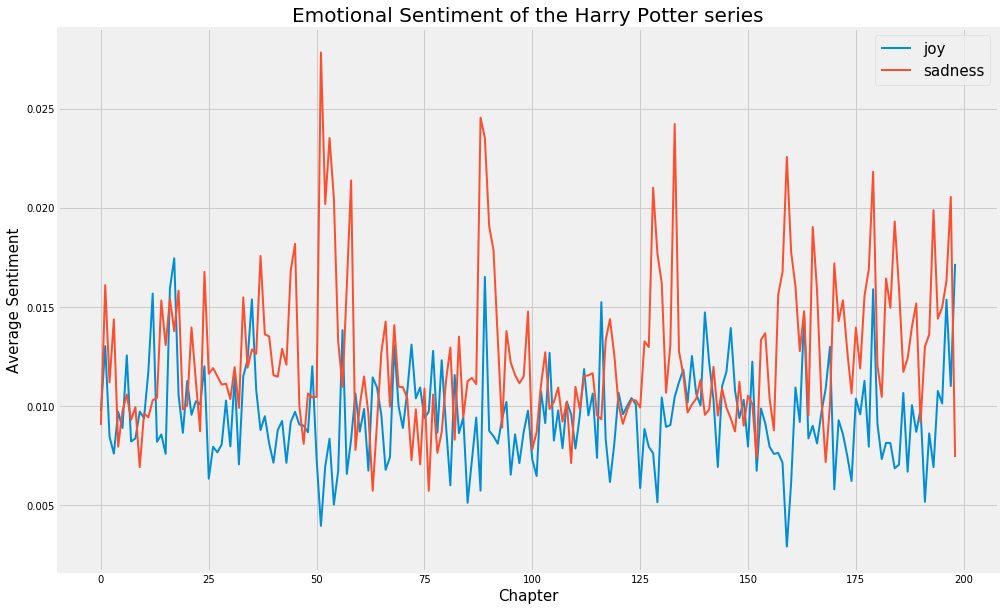

In [59]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)

plt.figure(figsize=(15, 10))
for emotion in ['joy', 'sadness']:
    y = [hp_df.loc[book].loc[hp[book][chapter][0]][emotion] for book in hp for chapter in hp[book]]
    plt.plot(x, y, linewidth=2, label=emotion)
# plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Emotional Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

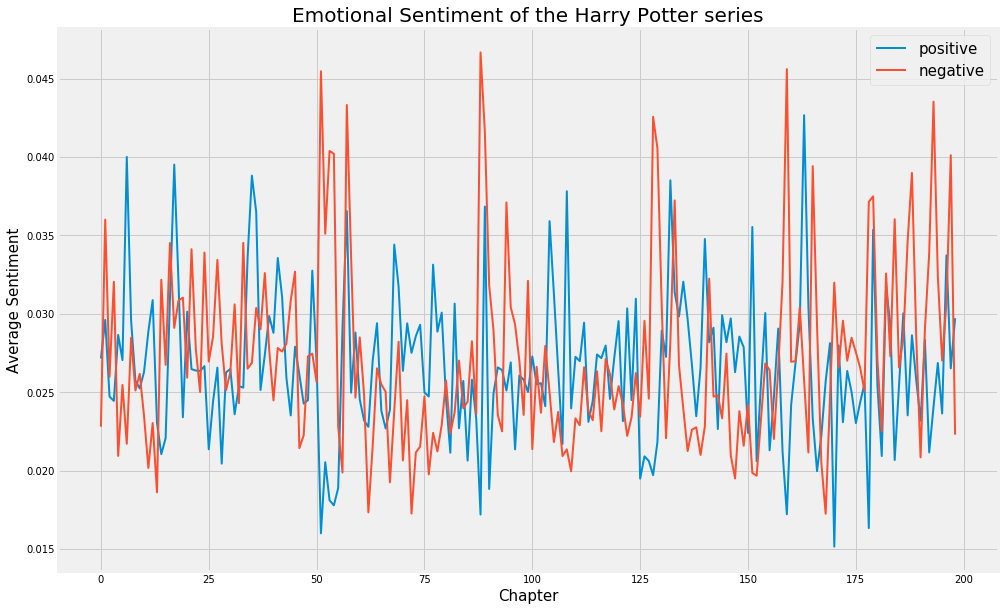

In [60]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)

plt.figure(figsize=(15, 10))
for emotion in ['positive', 'negative']:
    y = [hp_df.loc[book].loc[hp[book][chapter][0]][emotion] for book in hp for chapter in hp[book]]
    plt.plot(x, y, linewidth=2, label=emotion)
# plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Emotional Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

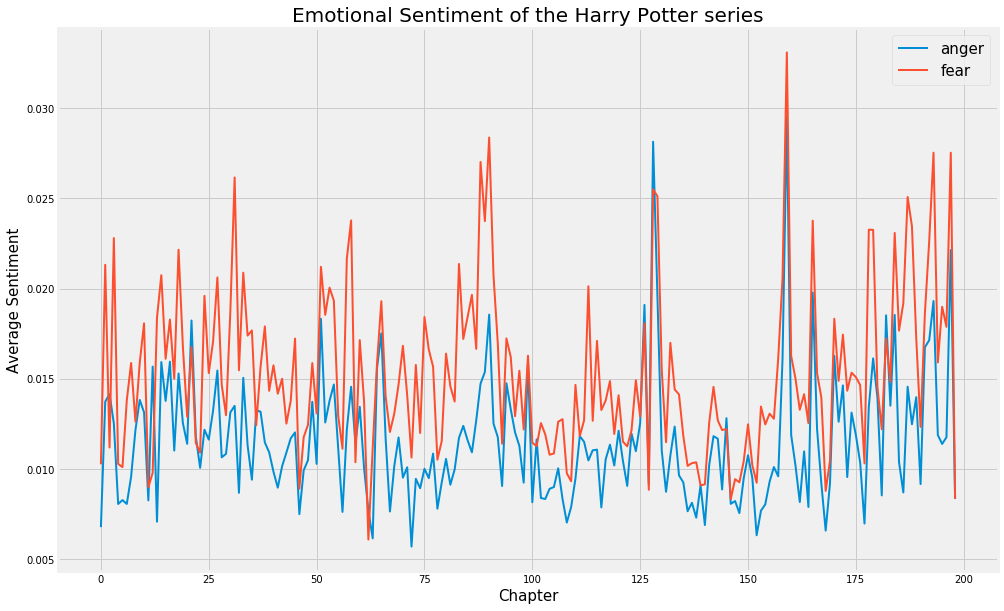

In [61]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)

plt.figure(figsize=(15, 10))
for emotion in ['anger', 'fear']:
    y = [hp_df.loc[book].loc[hp[book][chapter][0]][emotion] for book in hp for chapter in hp[book]]
    plt.plot(x, y, linewidth=2, label=emotion)
# plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Emotional Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

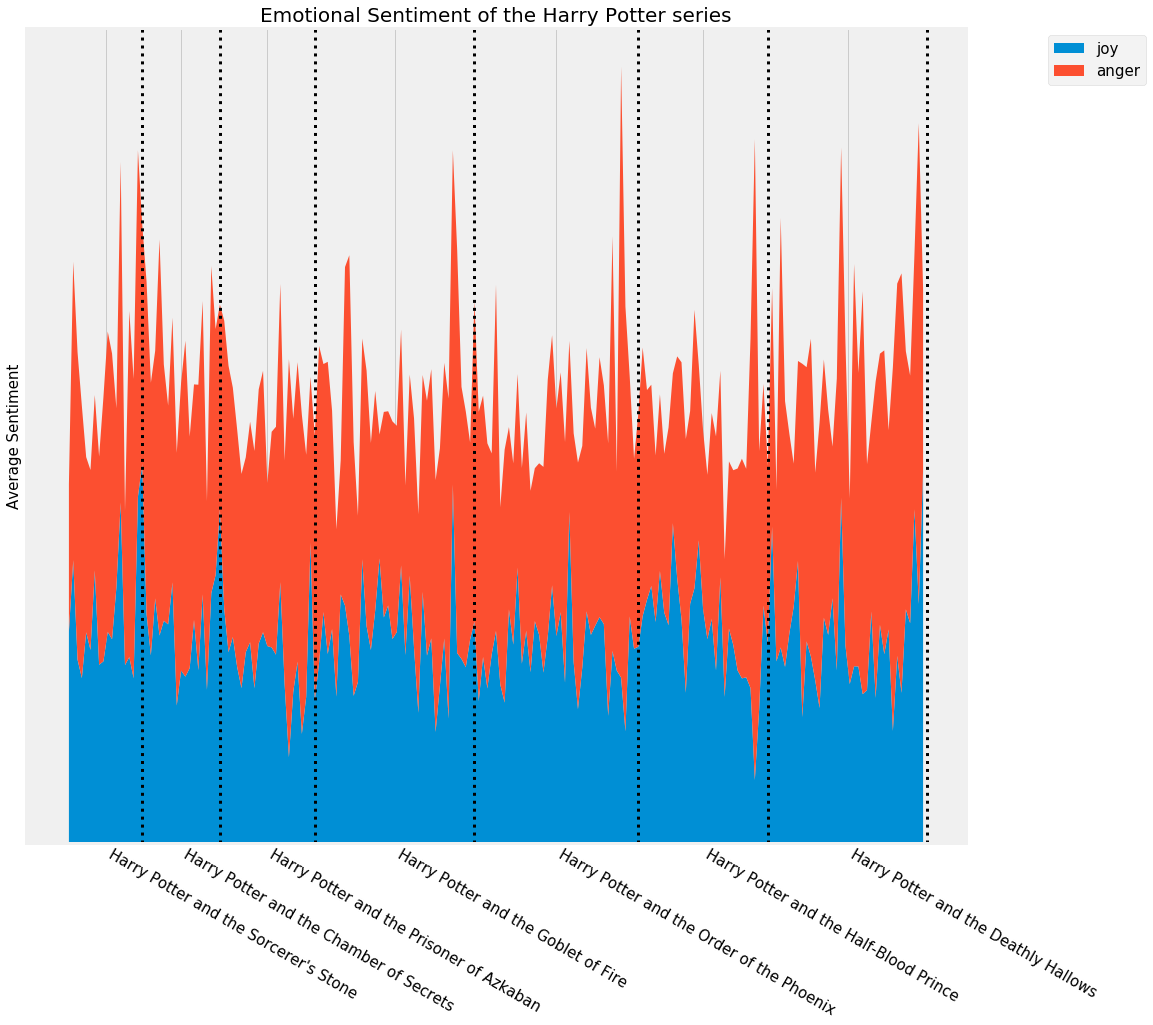

In [80]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)

plt.figure(figsize=(15, 15))
y = [hp_df[emotion].tolist() for emotion in ['joy', 'anger']]
plt.stackplot(x, y, labels=['joy', 'anger'])
for book in book_indices:
    plt.axvline(x=book_indices[book][1], color='black', linewidth=3, linestyle=':')
plt.legend(loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of the Harry Potter series', fontsize=20)
plt.xticks([(book_indices[book][0] + book_indices[book][1]) / 2 for book in book_indices],
           list(hp),
           rotation=-30,
           fontsize=15,
           ha='left')
plt.yticks([])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

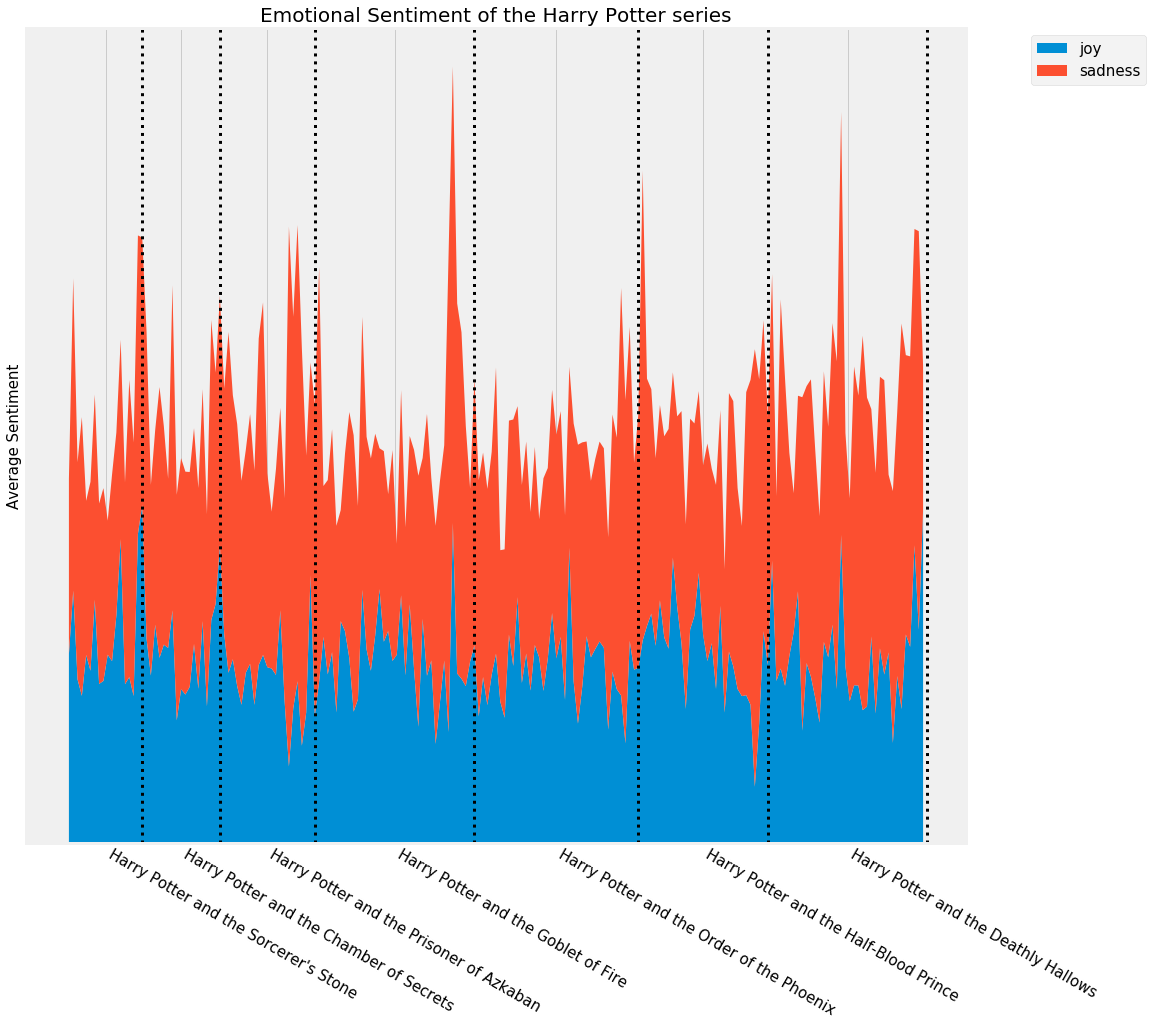

In [79]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)
emots = ['joy', 'sadness']

plt.figure(figsize=(15, 15))
y = [hp_df[emotion].tolist() for emotion in emots]
plt.stackplot(x, y, labels=emots)
for book in book_indices:
    plt.axvline(x=book_indices[book][1], color='black', linewidth=3, linestyle=':')
plt.legend(loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of the Harry Potter series', fontsize=20)
plt.xticks([(book_indices[book][0] + book_indices[book][1]) / 2 for book in book_indices],
           list(hp),
           rotation=-30,
           fontsize=15,
           ha='left')
plt.yticks([])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

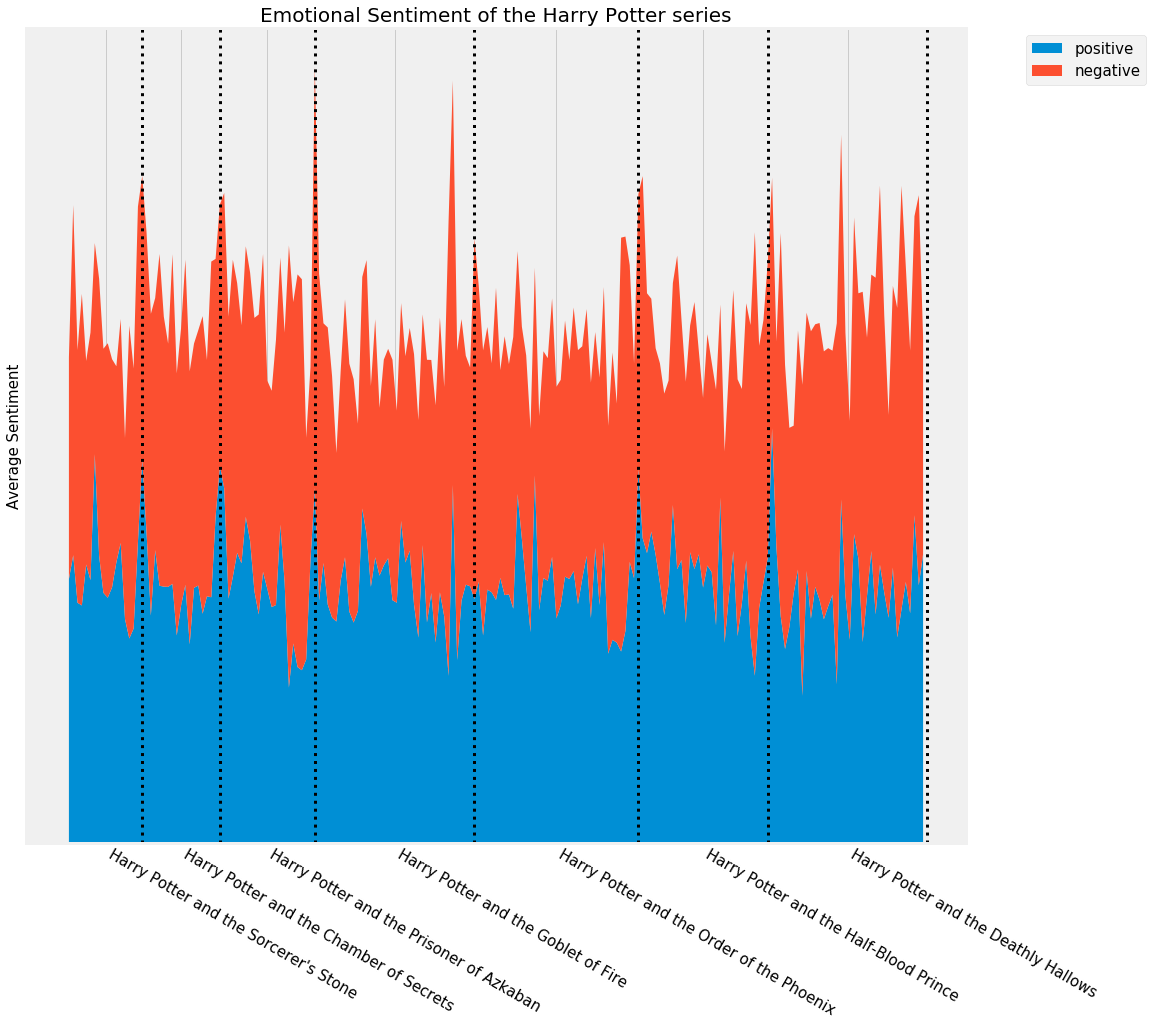

In [78]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)
emots = ['positive', 'negative']

plt.figure(figsize=(15, 15))
y = [hp_df[emotion].tolist() for emotion in emots]
plt.stackplot(x, y, labels=emots)
for book in book_indices:
    plt.axvline(x=book_indices[book][1], color='black', linewidth=3, linestyle=':')
plt.legend(loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of the Harry Potter series', fontsize=20)
plt.xticks([(book_indices[book][0] + book_indices[book][1]) / 2 for book in book_indices],
           list(hp),
           rotation=-30,
           fontsize=15,
           ha='left')
plt.yticks([])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

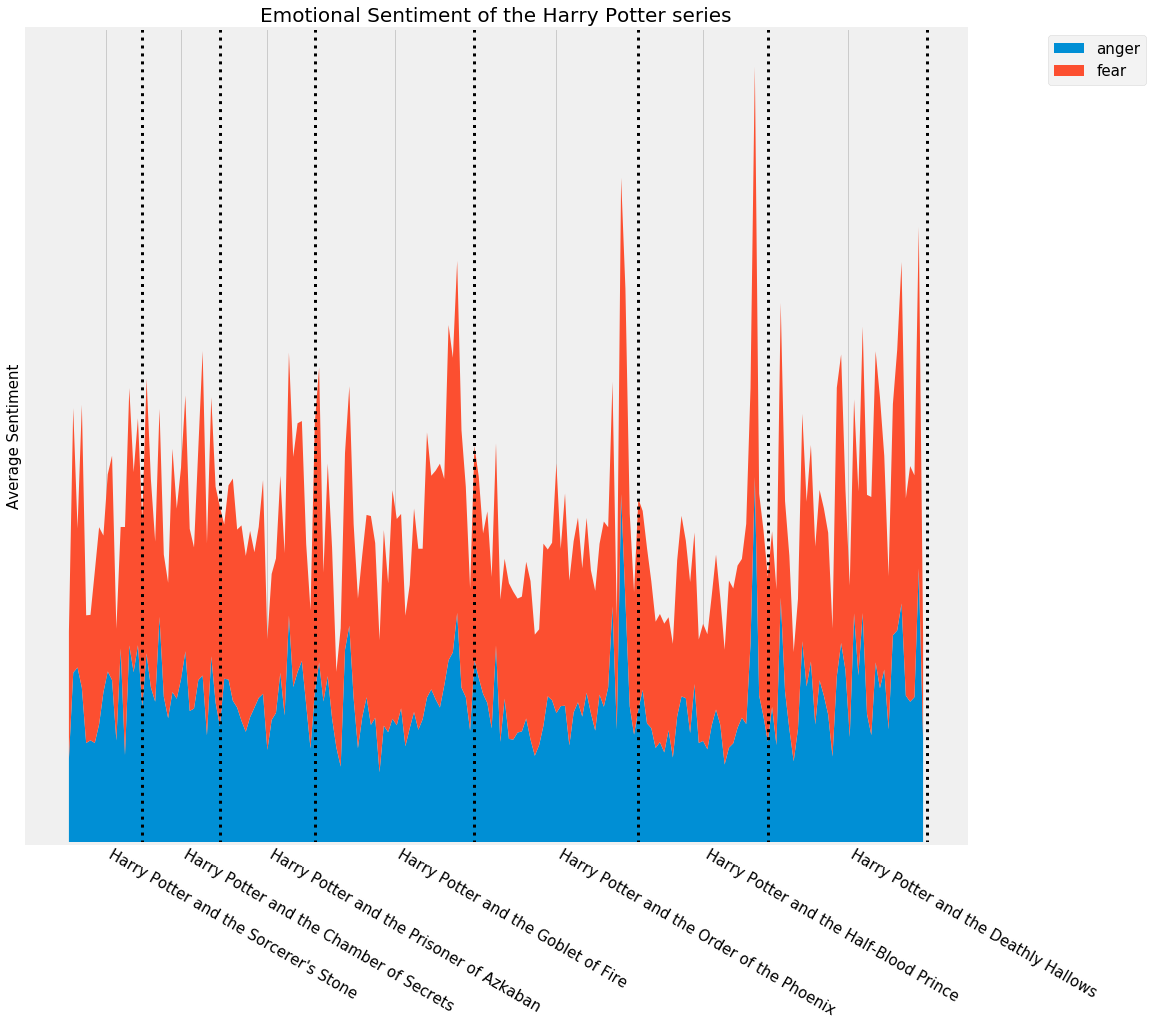

In [65]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)
emots = ['anger', 'fear']

plt.figure(figsize=(15, 15))
y = [hp_df[emotion].tolist() for emotion in emots]
plt.stackplot(x, y, labels=emots)
for book in book_indices:
    plt.axvline(x=book_indices[book][1], color='black', linewidth=3, linestyle=':')
plt.legend(loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of the Harry Potter series', fontsize=20)
plt.xticks([(book_indices[book][0] + book_indices[book][1]) / 2 for book in book_indices],
           list(hp),
           rotation=-30,
           fontsize=15,
           ha='left')
plt.yticks([])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

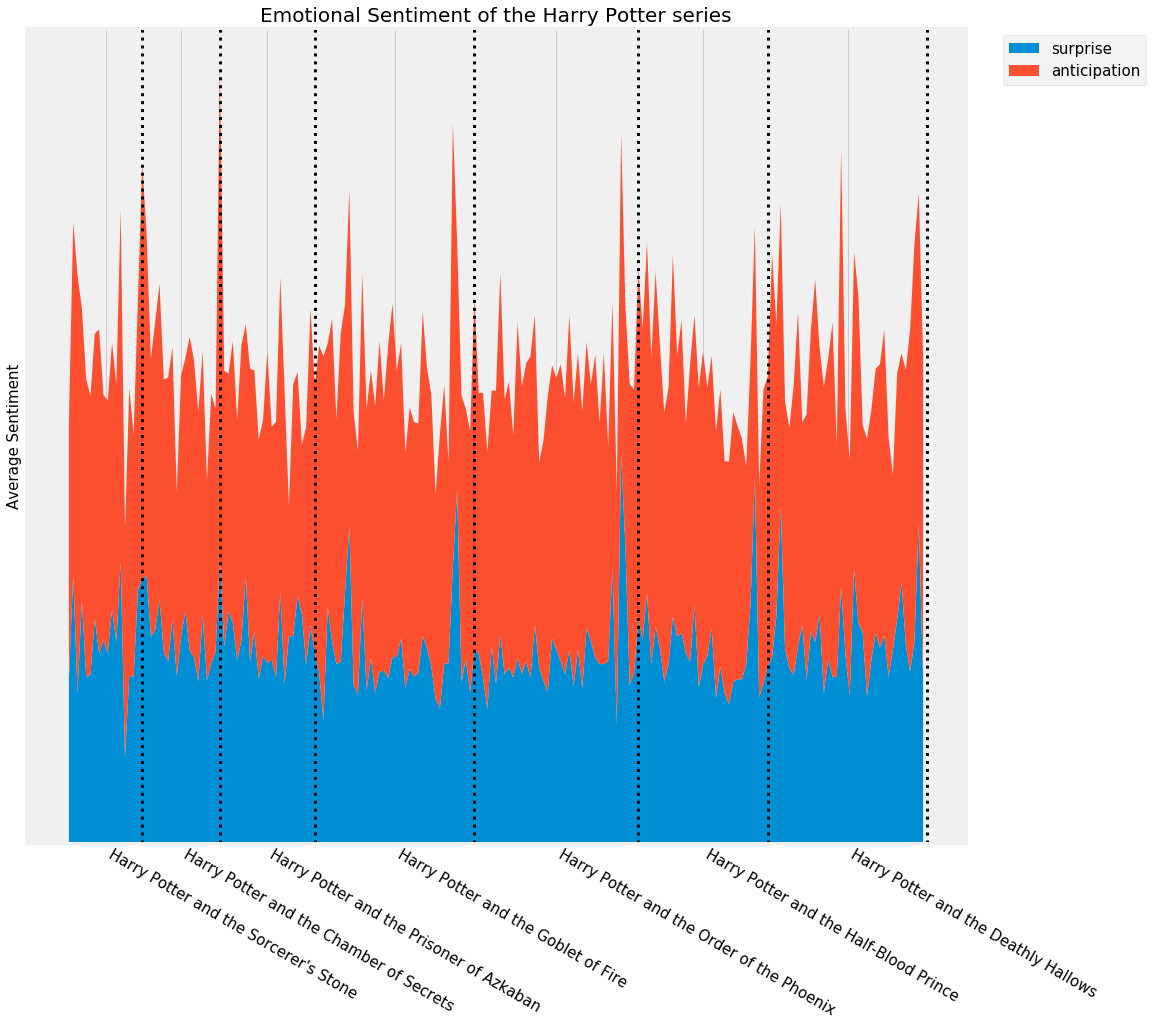

In [66]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)
emots = ['surprise', 'anticipation']

plt.figure(figsize=(15, 15))
y = [hp_df[emotion].tolist() for emotion in emots]
plt.stackplot(x, y, labels=emots)
for book in book_indices:
    plt.axvline(x=book_indices[book][1], color='black', linewidth=3, linestyle=':')
plt.legend(loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of the Harry Potter series', fontsize=20)
plt.xticks([(book_indices[book][0] + book_indices[book][1]) / 2 for book in book_indices],
           list(hp),
           rotation=-30,
           fontsize=15,
           ha='left')
plt.yticks([])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

In [67]:
hp_df2 = hp_df.groupby('book').mean().reindex([book for book in hp])

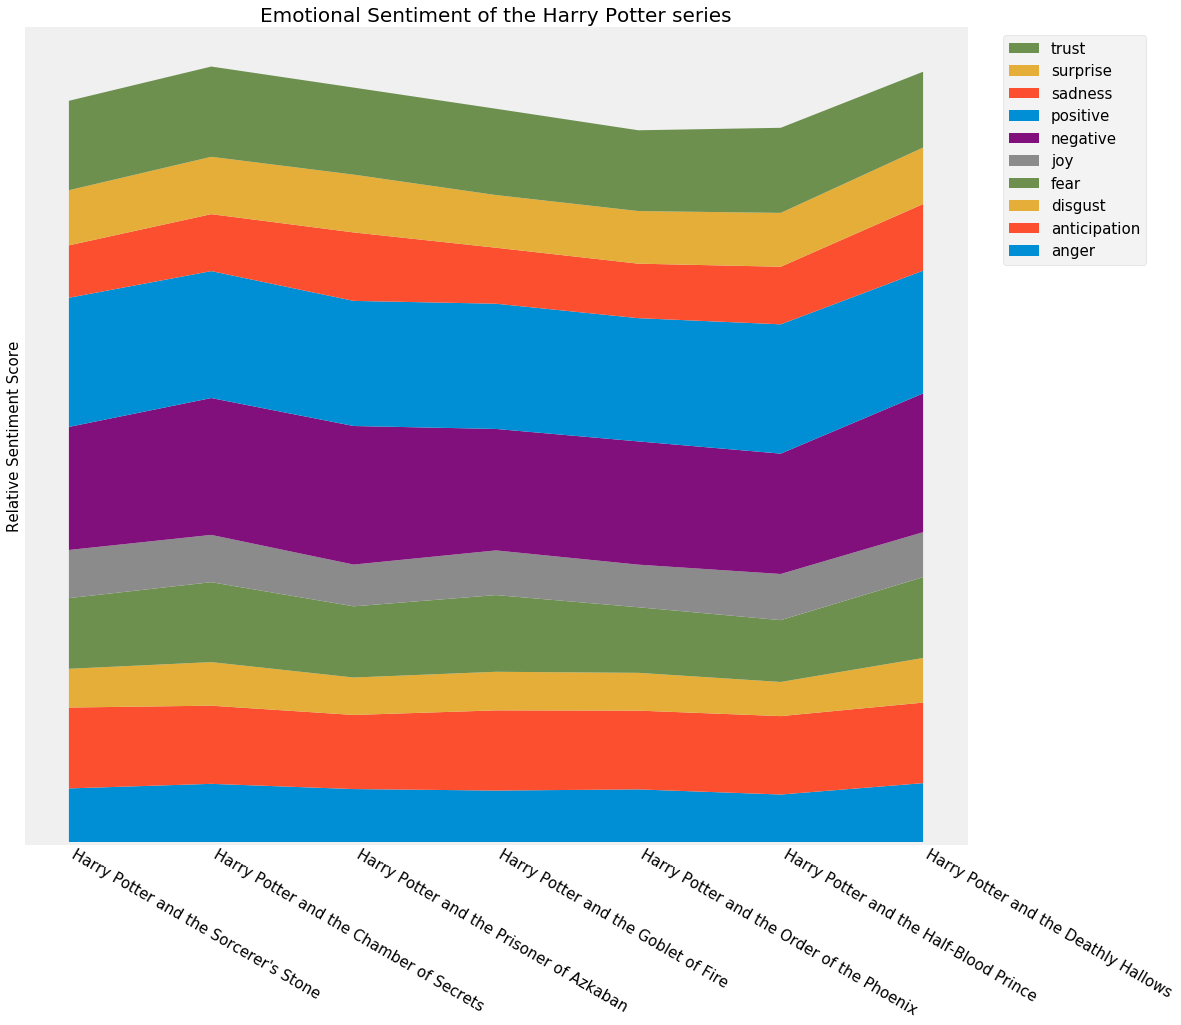

In [68]:
length = len(hp)
x = np.linspace(0, length - 1, num=length)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1,1)

y = [hp_df2[emotion].tolist() for emotion in emotions]
plt.stackplot(list(hp), y, labels=emotions)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of the Harry Potter series', fontsize=20)
plt.xticks(list(hp), list(hp), rotation=-30, ha='left', fontsize=15)
plt.ylabel('Relative Sentiment Score', fontsize=15)
plt.yticks([])
ax.grid(False)
plt.show()

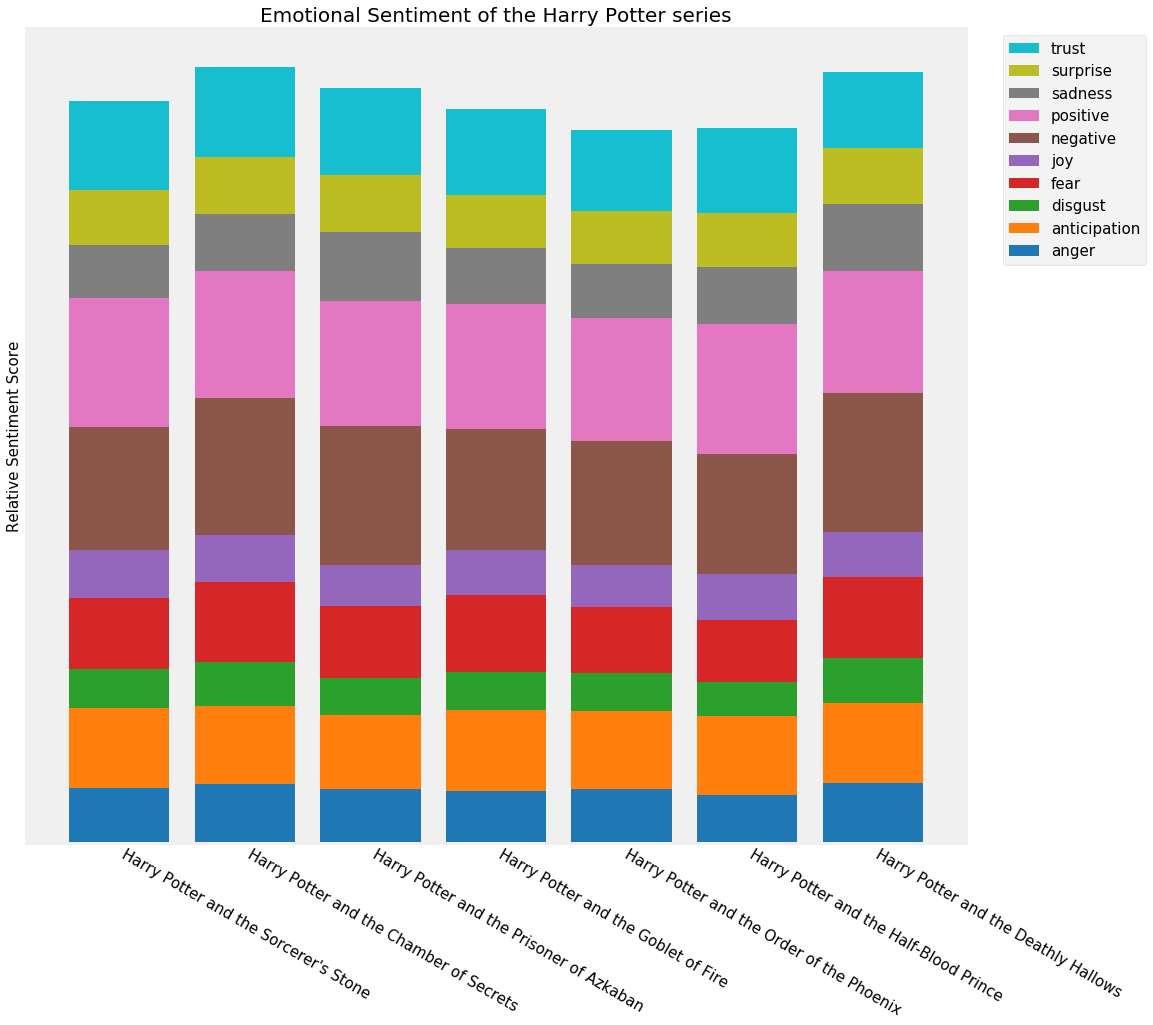

In [69]:
books = list(hp)
margin_bottom = np.zeros(len(books))

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)

for c, emotion in enumerate(emotions):
    y = np.array(hp_df2[emotion])
    plt.bar(books, y, bottom=margin_bottom, label=emotion, color=(tab10(c)))
    margin_bottom += y

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of the Harry Potter series', fontsize=20)
plt.xticks(books, books, rotation=-30, ha='left', fontsize=15)
plt.ylabel('Relative Sentiment Score', fontsize=15)
plt.yticks([])
ax.grid(False)
plt.show()

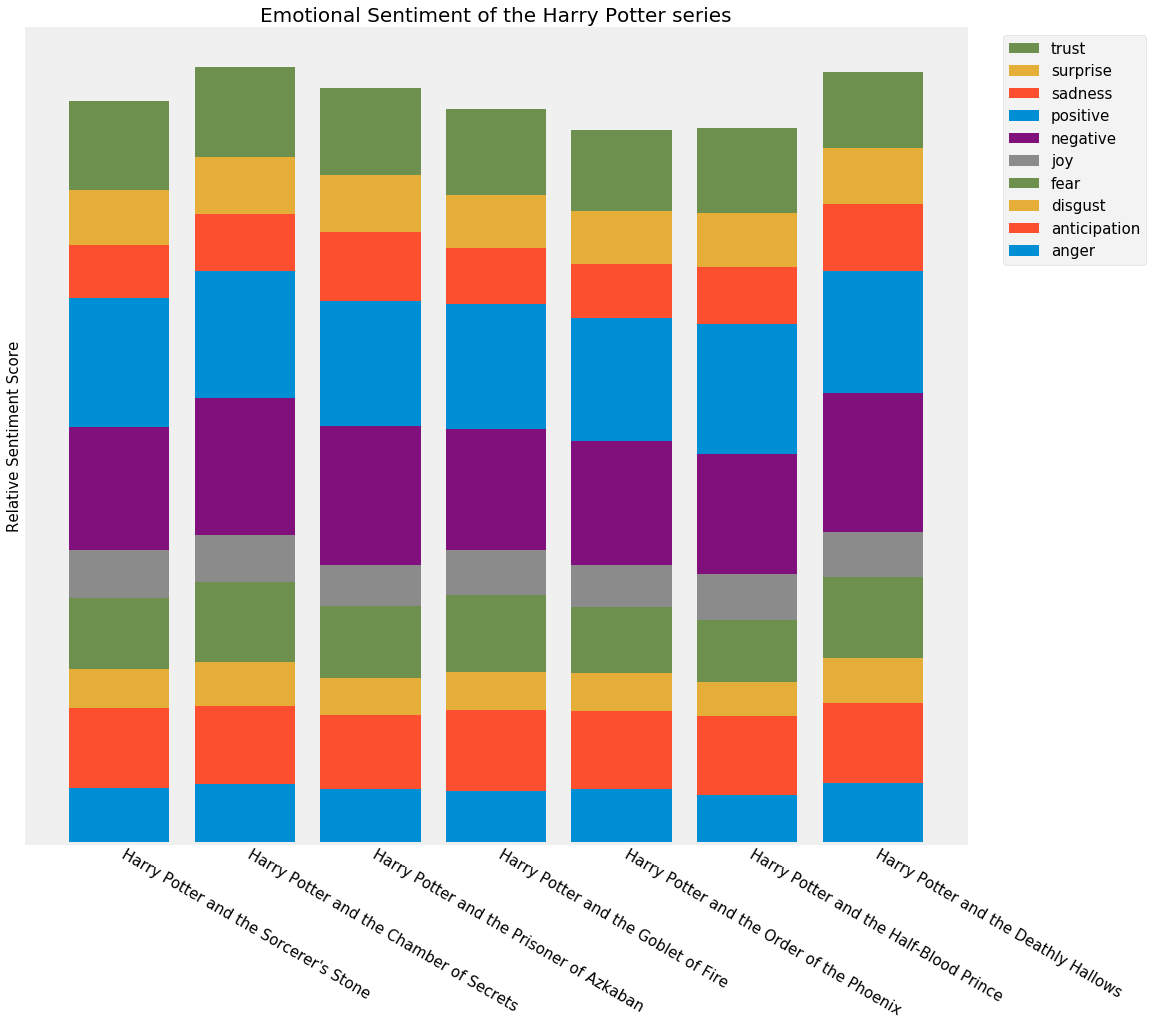

In [70]:
books = list(hp)
margin_bottom = np.zeros(len(books))

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)

for idx, emotion in enumerate(emotions):
    y = np.array(hp_df2[emotion])
    plt.bar(books, y, bottom=margin_bottom, label=emotion) #emotions[len(emotions) - idx - 1])
    margin_bottom += y
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of the Harry Potter series', fontsize=20)
plt.xticks(books, books, rotation=-30, ha='left', fontsize=15)
plt.ylabel('Relative Sentiment Score', fontsize=15)
plt.yticks([])
ax.grid(False)
plt.show()